In [3]:
!pip install pytorch-toolbelt --quiet
!pip install torchinfo --quiet
!pip install einops --quiet
!pip install medpy torchmetrics --quiet
!pip install thop --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.1/170.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
!git clone https://github.com/LeeJunHyun/Image_Segmentation
!git clone https://github.com/gorkemcanates/Dual-Cross-Attention
!mv Dual-Cross-Attention Dual_Cross_Attention

Cloning into 'Image_Segmentation'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 54 (delta 0), reused 0 (delta 0), pack-reused 53 (from 3)
Receiving objects: 100% (54/54), 265.65 KiB | 12.65 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Cloning into 'Dual-Cross-Attention'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 342 (delta 104), reused 109 (delta 49), pack-reused 124 (from 1)
Receiving objects: 100% (342/342), 4.72 MiB | 28.77 MiB/s, done.
Resolving deltas: 100% (168/168), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# dataset: https://www.kaggle.com/datasets/c7934597/cardiac-catheterization

%mkdir dataset
!unzip -o '/content/drive/MyDrive/cardiac-catheterization.zip' -d 'dataset'

Archive:  /content/drive/MyDrive/cardiac-catheterization.zip
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_47.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_48.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_49.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_50.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_51.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_52.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_53.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_54.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_55.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_56.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_57.png  
  inflating: dataset/Cardiac_Catheterization/train/images/0655[0]_58.png  
  inflating: dataset/Cardiac_Catheteriz

In [6]:

from sklearn.metrics import confusion_matrix, f1_score
from torchmetrics.functional import jaccard_index as torch_jaccard_index
from medpy.metric.binary import hd95
import torchinfo

import os
import random
from matplotlib import pyplot as plt

import numpy as np
import cv2

from torch import nn
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from pytorch_toolbelt.losses.lovasz import BinaryLovaszLoss

from sklearn.model_selection import train_test_split

cudnn.benchmark = True
cuda = torch.cuda.is_available()

/usr/local/lib/python3.11/dist-packages/pytorch_toolbelt/losses/functional.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(False)
/usr/local/lib/python3.11/dist-packages/pytorch_toolbelt/losses/quality_focal_loss.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(False)


#Loading Data

In [7]:
images_directory = 'dataset/Cardiac_Catheterization/train/images/'
masks_directory = 'dataset/Cardiac_Catheterization/train/masks/'

images_files = os.listdir(images_directory)
masks_files = os.listdir(masks_directory)

sample_image = cv2.imread(images_directory + images_files[0], flags=cv2.IMREAD_GRAYSCALE)

print('images count: ' + str(len(images_files)))
print('images shape: ' + str(sample_image.shape))

images count: 1717
images shape: (512, 512)


In [8]:
image_size = 128
images = []
masks = []

for i, image_name in enumerate(images_files):
    image = cv2.imread(images_directory + image_name, flags=cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (image_size, image_size))
    images.append(image)

for i, image_name in enumerate(masks_files):
    image = cv2.imread(masks_directory + image_name, flags=cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (image_size, image_size))
    masks.append(image)

print('images shape: ' + str(images[0].shape))
print('masks shape: ' + str(masks[0].shape))

images shape: (128, 128)
masks shape: (128, 128)


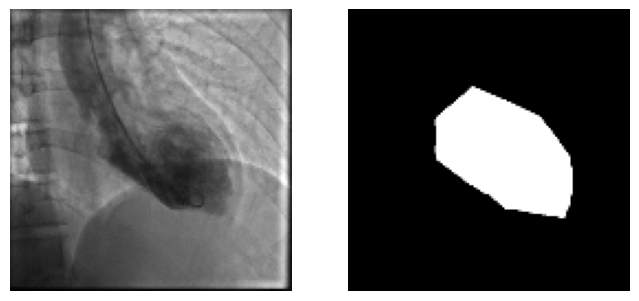

In [9]:
idx = random.randint(0, len(images))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(images[idx], cmap='gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(masks[idx], cmap='gray')
plt.show()

In [10]:
batch_size = 16

class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image = image.astype(np.float32)
        mask = mask.astype(np.float32)

        image = torch.from_numpy(image / 255.0).unsqueeze(0)
        mask = torch.from_numpy(mask / 255.0).unsqueeze(0)

        return image, mask


x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=0)

train_dataset = Dataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = Dataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

len(train_loader) * batch_size, len(test_loader) * batch_size

(1360, 336)

#Model

In [11]:
# accuracy metric

def accuracy(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    correct = (y_true == y_pred).sum()

    accuracy = correct / float(y_true.numel())

    return accuracy


def jaccard_index(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    intersection = (y_true * y_pred).sum()
    union = torch.logical_or(y_true, y_pred).sum()

    jaccard = torch.where(union != 0.0, intersection / union, torch.tensor(0.0))

    return jaccard


def dice_coefficient(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum()

    dice = torch.where(union != 0.0, (2 * intersection) / union, torch.tensor(0.0))

    return dice


def sensitivity(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    tp = (y_true * y_pred).sum()
    fn = (y_true * (1 - y_pred)).sum()
    return tp / (tp + fn + 1e-8)

def specificity(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    tn = ((1 - y_true) * (1 - y_pred)).sum()
    fp = ((1 - y_true) * y_pred).sum()
    return tn / (tn + fp + 1e-8)

def f1_score_metric(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    y_true = y_true.int().flatten().cpu().numpy()
    y_pred = y_pred.int().flatten().cpu().numpy()
    return torch.tensor(f1_score(y_true, y_pred))

def hausdorff_distance(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    y_true = y_true.squeeze().cpu().numpy().astype(bool)
    y_pred = y_pred.squeeze().cpu().numpy().astype(bool)
    try:
        return torch.tensor(hd95(y_true, y_pred))
    except:
        return torch.tensor(0.0)

def miou_metric(y_true, y_pred):
    y_pred = (y_pred > 0.5).int()
    return torch_jaccard_index(y_pred, y_true.int(), num_classes=2, task='binary')

In [12]:
class OneConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OneConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=(1, 1)),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.double_conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.pool(x)
        x = self.double_conv(x)
        return x


class DownRes(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DownRes, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.mp_conv = DoubleConv(in_ch, out_ch)
        self.bridge = OneConv(in_ch, out_ch)

    def forward(self, x):
        x = self.pool(x)
        x_1 = self.mp_conv(x)
        x_2 = self.bridge(x)
        x = x_1 + x_2
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        padding = [(x1.size()[2] - x2.size()[2]) // 2, (x1.size()[2] - x2.size()[2] + 1) // 2,
                   (x1.size()[3] - x2.size()[3]) // 2, (x1.size()[3] - x2.size()[3] + 1) // 2]
        x2 = nn.functional.pad(x2, padding)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class UpRes(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(UpRes, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=(2, 2), stride=(2, 2))

        self.conv = DoubleConv(in_ch, out_ch)
        self.bridge = OneConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        padding = [(x1.size()[2] - x2.size()[2]) // 2, (x1.size()[2] - x2.size()[2] + 1) // 2,
                   (x1.size()[3] - x2.size()[3]) // 2, (x1.size()[3] - x2.size()[3] + 1) // 2]
        x2 = nn.functional.pad(x2, padding)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x) + self.bridge(x)
        return x


class Model(nn.Module):
    def __init__(self, model_type, n_channels=1, n_classes=1):
        super(Model, self).__init__()
        f = 4

        self.in_conv = DoubleConv(n_channels, f)

        if model_type == 'UNet':
            self.down1 = Down(f, f * 2)
            self.down2 = Down(f * 2, f * 4)
            self.down3 = Down(f * 4, f * 8)
            self.down4 = Down(f * 8, f * 8)

            self.up1 = Up(f * 16, f * 4)
            self.up2 = Up(f * 8, f * 2)
            self.up3 = Up(f * 4, f)
            self.up4 = Up(f * 2, f)

        elif model_type == 'ResNet':
            self.down1 = DownRes(f, f * 2)
            self.down2 = DownRes(f * 2, f * 4)
            self.down3 = DownRes(f * 4, f * 8)
            self.down4 = DownRes(f * 8, f * 8)

            self.up1 = UpRes(f * 16, f * 4)
            self.up2 = UpRes(f * 8, f * 2)
            self.up3 = UpRes(f * 4, f)
            self.up4 = UpRes(f * 2, f)

        self.out = OneConv(f, n_classes)

        if n_classes == 1:
            self.out_activation = F.sigmoid
        elif n_classes > 1:
            self.out_activation = F.softmax

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.out(x)
        return self.out_activation(x)

In [13]:

class ModelFit:
    def __init__(self, model, criterion=None, optimizer=None, metrics=None):
        self.model = model
        self.criterion = criterion if criterion is not None else nn.BCELoss()
        self.optimizer = optimizer if optimizer is not None else torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.metrics = metrics if metrics is not None else [
            accuracy,
            dice_coefficient,
            jaccard_index,
            sensitivity,
            specificity,
            f1_score_metric,
            hausdorff_distance,
            miou_metric,
        ]
        self.metrics_names = [f.__name__ for f in self.metrics]

        self.train_loader = None
        self.test_loader = None

        self.cuda = torch.cuda.is_available()
        if self.cuda:
            self.model.cuda()
            self.criterion.cuda()

    def _train_batch(self, inputs, targets):
        if self.cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        loss.backward()
        self.optimizer.step()
        metrics = [metric(targets, outputs).item() for metric in self.metrics]

        return loss.item(), metrics

    def _test_batch(self, inputs, targets):
        if self.cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        metrics = [metric(targets, outputs).item() for metric in self.metrics]

        return loss.item(), metrics

    def _train_epoch(self, epoch, epochs):
        self.model.train()

        epoch_loss = 0
        epoch_metrics = np.zeros((len(self.metrics)))
        batches_n = len(self.train_loader)
        i = 0

        for inputs, targets in self.train_loader:
            i += 1

            loss, metrics = self._train_batch(inputs, targets)

            epoch_loss += loss
            epoch_metrics += np.array(metrics)

            info = f"\rEpoch: {f'{epoch}/{epochs}':<7} Batch: {f'{i}/{batches_n}':<7} [ loss: {epoch_loss / i:.4f}"
            for n in range(len(self.metrics)):
                info += f" - {self.metrics_names[n]}: {epoch_metrics[n] / i:.4f}"
            info += " ]"

            print(info, end='')

        epoch_loss /= batches_n
        epoch_metrics /= batches_n
        return epoch_loss, epoch_metrics

    def _test_epoch(self):
        self.model.eval()

        epoch_loss = 0
        epoch_metrics = np.zeros((len(self.metrics)))
        batches_n = len(self.test_loader)

        for inputs, targets in self.test_loader:
            loss, metrics = self._test_batch(inputs, targets)

            epoch_loss += loss
            epoch_metrics += np.array(metrics)

        epoch_loss /= batches_n
        epoch_metrics /= batches_n

        info = f" [ val_loss: {epoch_loss:.4f}"
        for n in range(len(self.metrics)):
            info += f" - val_{self.metrics_names[n]}: {epoch_metrics[n]:.4f}"
        info += " ]"

        print(info)

        return epoch_loss, epoch_metrics

    def fit(self, train_loader, epochs, test_loader=None):
        self.train_loader = train_loader
        self.test_loader = test_loader

        train_loss_history = []
        train_metrics_history = []
        test_loss_history = []
        test_metrics_history = []

        for epoch in range(epochs):
            loss, train_metrics = self._train_epoch(epoch + 1, epochs)
            train_loss_history.append(loss)
            train_metrics_history.append(train_metrics)

            if self.test_loader is not None:
                test_loss, test_metrics = self._test_epoch()
                test_loss_history.append(test_loss)
                test_metrics_history.append(test_metrics)

        result = {}
        result['train_loss'] = train_loss_history
        result['val_loss'] = test_loss_history

        for i, metric in enumerate(zip(*train_metrics_history)):
            result['train_' + self.metrics_names[i]] = metric

        for i, metric in enumerate(zip(*test_metrics_history)):
            result['val_' + self.metrics_names[i]] = metric

        print('\n')
        return result

    def evaluate(self):
        pass

In [14]:
# plotting

def plot_metric(history, metric):
    plt.figure(figsize=(10, 4))

    epochs = range(1, len(history['train_' + metric]) + 1)

    plt.plot(epochs, history['train_' + metric], label='train ' + metric)
    plt.plot(epochs, history['val_' + metric], label='test ' + metric)

    plt.xlabel('epoch')
    plt.ylabel(metric)

    plt.legend()
    plt.grid(True)

    plt.show()


def evaluate(model, data_loader, metric=dice_coefficient):
    model.eval()

    if cuda:
        model.cuda()

    s = 0
    batches_n = len(data_loader)

    for inputs, targets in data_loader:
        if cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()

        outputs = model(inputs)
        s += metric(targets, outputs)

    result = (s / batches_n)
    if torch.is_tensor(result):
        result = result.item()
    return result


def tensor_to_numpy_image(img):
    img = img.cpu()
    img = img.data.numpy().astype(np.float32)
    return img.T


def check(model, idx=None):
    model.eval()

    if idx is None:
        idx = random.randint(0, len(test_dataset))

    x, y = test_dataset[idx]

    inputs = x.unsqueeze(0)
    if cuda:
        inputs = inputs.cuda()

    y_pred = model(inputs)[0]
    y_pred = tensor_to_numpy_image(y_pred)

    prediction = (y_pred > 0.5)
    x = tensor_to_numpy_image(x)
    y = tensor_to_numpy_image(y)

    plt.figure(figsize=(8, 8))

    plt.subplot(2, 3, 1)
    plt.title('Image')
    plt.axis('off')
    plt.imshow(x, cmap='gray')

    plt.subplot(2, 3, 2)
    plt.title('Real Mask')
    plt.axis('off')
    plt.imshow(y, cmap='gray')

    plt.subplot(2, 3, 3)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.imshow(prediction, cmap='gray')

    plt.show()

#Loss Functions

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCELoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce_loss(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = (self.alpha * pt) * torch.pow(1.0 - pt, self.gamma)
        loss = focal_loss.mean()
        return loss


class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        intersection = (inputs * targets).sum()
        loss = 1 - (2 * intersection) / (inputs.sum() + targets.sum() + 1e-5)
        return loss


class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCELoss()
        self.dice_loss = DiceLoss()

    def forward(self, inputs, targets):
        dice_loss = self.dice_loss(inputs, targets)
        bce_loss = self.bce_loss(inputs, targets)
        loss = 0.5 * (dice_loss + bce_loss)
        return loss


class HybridLoss(nn.Module):
    def __init__(self):
        super(HybridLoss, self).__init__()
        self.bce_loss = nn.BCELoss()
        self.dice_loss = DiceLoss()

        self.sobel_x = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.sobel_y = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

        self.sobel_x.weight.data.copy_(torch.tensor([[-1, 0, 1], [2, 0, -2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3))
        self.sobel_y.weight.data.copy_(torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).view(1, 1, 3, 3))

    def compute_length(self, inputs):
        seg_channel = torch.argmax(inputs, dim=1, keepdim=True).float()

        edges_x = self.sobel_x(seg_channel)
        edges_y = self.sobel_y(seg_channel)
        edges = torch.square(edges_x) + torch.square(edges_y)
        length = torch.sum(edges, dim=[1, 2, 3])

        length = torch.mean(length + 1e-6)

        return length

    def forward(self, inputs, targets):
        bce_loss = self.bce_loss(inputs, targets)
        dice_loss = self.dice_loss(inputs, targets)
        length = self.compute_length(inputs)

        return bce_loss - 0.1 * dice_loss + length


class LovaszBCELoss(nn.Module):
    def __init__(self):
        super(LovaszBCELoss, self).__init__()
        self.bce_loss = nn.BCELoss()
        self.lovasz_loss = BinaryLovaszLoss()

    def forward(self, inputs, targets):
        loss = self.bce_loss(inputs, targets) + self.lovasz_loss(inputs, targets)
        return loss

#Checking model with different losses

In [16]:
epochs = 20

models = []
base_models_names = []
base_accuracies = []

def check_loss(model_type, criterion):

    from torchinfo import summary
    from thop import profile

    model = Model(model_type)
    dummy_input = torch.randn(1, 1, image_size, image_size)

    if torch.cuda.is_available():
        model = model.cuda()
        dummy_input = dummy_input.cuda()

    macs, params = profile(model, inputs=(dummy_input,), verbose=False)
    print(f"FLOPs: {macs / 1e6:.2f} MFLOPs")
    print(f"Number of Parameters: {params / 1e6:.2f} M")
    model = Model(model_type)
    model_fit = ModelFit(model, criterion)
    history = model_fit.fit(train_loader=train_loader, test_loader=test_loader, epochs=epochs)

    models.append(model)
    name = f"{model_type} model with {criterion.__class__.__name__}"
    base_models_names.append(name)
    base_accuracies.append(history['val_dice_coefficient'][-1])

    plot_metric(history, 'dice_coefficient')

    for i in range(0):
        print()
        check(model, i)

UNet model with MSELoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.2431 - accuracy: 0.7255 - dice_coefficient: 0.5864 - jaccard_index: 0.4423 - sensitivity: 0.9154 - specificity: 0.6939 - f1_score_metric: 0.5837 - hausdorff_distance: 29.9342 - miou_metric: 0.4412 ] [ val_loss: 0.2227 - val_accuracy: 0.9511 - val_dice_coefficient: 0.8571 - val_jaccard_index: 0.7466 - val_sensitivity: 0.9293 - val_specificity: 0.9575 - val_f1_score_metric: 0.8548 - val_hausdorff_distance: 9.8248 - val_miou_metric: 0.7467 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.2195 - accuracy: 0.9679 - dice_coefficient: 0.9044 - jaccard_index: 0.8212 - sensitivity: 0.9189 - specificity: 0.9796 - f1_score_metric: 0.9035 - hausdorff_distance: 2.6521 - miou_metric: 0.8247 ] [ val_loss: 0.2192 - val_accuracy: 0.9725 - val_dice_coefficient: 0.9189 - val_jaccard_index: 0.8457 - val_sensitivity: 0.9478 - val_specificity: 0.9795 - val_f1_score_metric: 0.9166 - val_hausdorff_distan

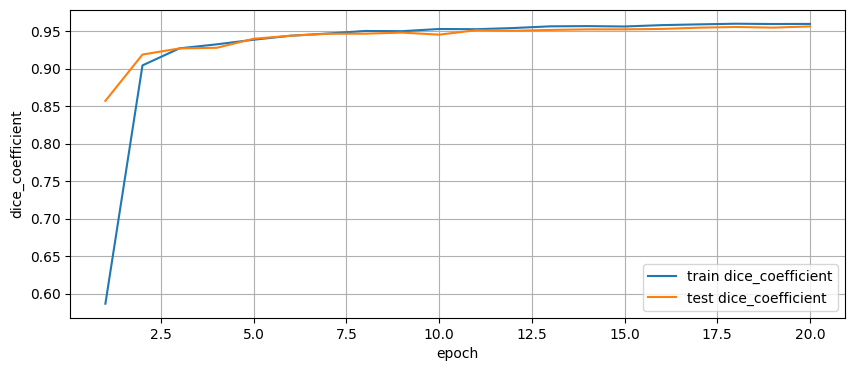


ResNet model with MSELoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.2367 - accuracy: 0.7940 - dice_coefficient: 0.6743 - jaccard_index: 0.5472 - sensitivity: 0.9314 - specificity: 0.7713 - f1_score_metric: 0.6716 - hausdorff_distance: 21.3784 - miou_metric: 0.5464 ] [ val_loss: 0.2210 - val_accuracy: 0.9672 - val_dice_coefficient: 0.8995 - val_jaccard_index: 0.8123 - val_sensitivity: 0.9066 - val_specificity: 0.9806 - val_f1_score_metric: 0.8985 - val_hausdorff_distance: 2.0456 - val_miou_metric: 0.8159 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.2191 - accuracy: 0.9707 - dice_coefficient: 0.9134 - jaccard_index: 0.8361 - sensitivity: 0.9289 - specificity: 0.9812 - f1_score_metric: 0.9123 - hausdorff_distance: 1.8794 - miou_metric: 0.8390 ] [ val_loss: 0.2193 - val_accuracy: 0.9734 - val_dice_coefficient: 0.9203 - val_jaccard_index: 0.8476 - val_sensitivity: 0.9347 - val_specificity: 0.9828 - val_f1_score_metric: 0.9187 - val_hausdorff_dis

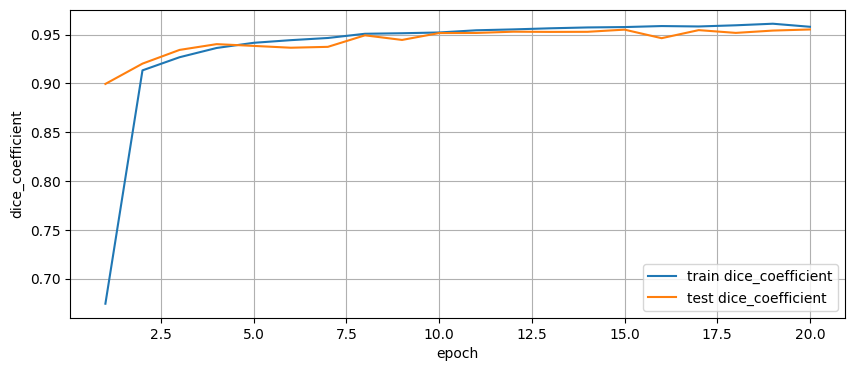


UNet model with BCELoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6425 - accuracy: 0.8885 - dice_coefficient: 0.7889 - jaccard_index: 0.6819 - sensitivity: 0.9058 - specificity: 0.8880 - f1_score_metric: 0.7872 - hausdorff_distance: 13.6895 - miou_metric: 0.6832 ] [ val_loss: 0.6222 - val_accuracy: 0.9710 - val_dice_coefficient: 0.9106 - val_jaccard_index: 0.8300 - val_sensitivity: 0.9042 - val_specificity: 0.9854 - val_f1_score_metric: 0.9102 - val_hausdorff_distance: 1.8226 - val_miou_metric: 0.8353 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.6172 - accuracy: 0.9732 - dice_coefficient: 0.9207 - jaccard_index: 0.8481 - sensitivity: 0.9274 - specificity: 0.9844 - f1_score_metric: 0.9197 - hausdorff_distance: 1.6010 - miou_metric: 0.8515 ] [ val_loss: 0.6179 - val_accuracy: 0.9750 - val_dice_coefficient: 0.9231 - val_jaccard_index: 0.8508 - val_sensitivity: 0.9102 - val_specificity: 0.9890 - val_f1_score_metric: 0.9234 - val_hausdorff_dista

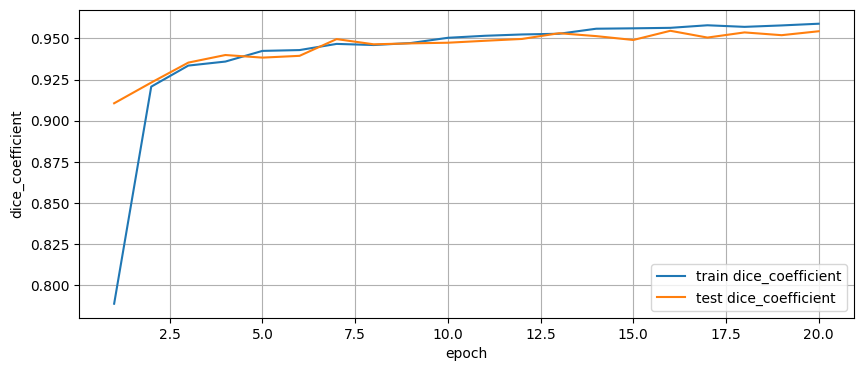


ResNet model with BCELoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6490 - accuracy: 0.8877 - dice_coefficient: 0.7659 - jaccard_index: 0.6475 - sensitivity: 0.8785 - specificity: 0.8922 - f1_score_metric: 0.7644 - hausdorff_distance: 14.9135 - miou_metric: 0.6494 ] [ val_loss: 0.6247 - val_accuracy: 0.9663 - val_dice_coefficient: 0.8942 - val_jaccard_index: 0.8024 - val_sensitivity: 0.8830 - val_specificity: 0.9838 - val_f1_score_metric: 0.8945 - val_hausdorff_distance: 2.3163 - val_miou_metric: 0.8093 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.6185 - accuracy: 0.9698 - dice_coefficient: 0.9101 - jaccard_index: 0.8303 - sensitivity: 0.9208 - specificity: 0.9818 - f1_score_metric: 0.9093 - hausdorff_distance: 1.8946 - miou_metric: 0.8340 ] [ val_loss: 0.6183 - val_accuracy: 0.9736 - val_dice_coefficient: 0.9202 - val_jaccard_index: 0.8465 - val_sensitivity: 0.9247 - val_specificity: 0.9850 - val_f1_score_metric: 0.9196 - val_hausdorff_dis

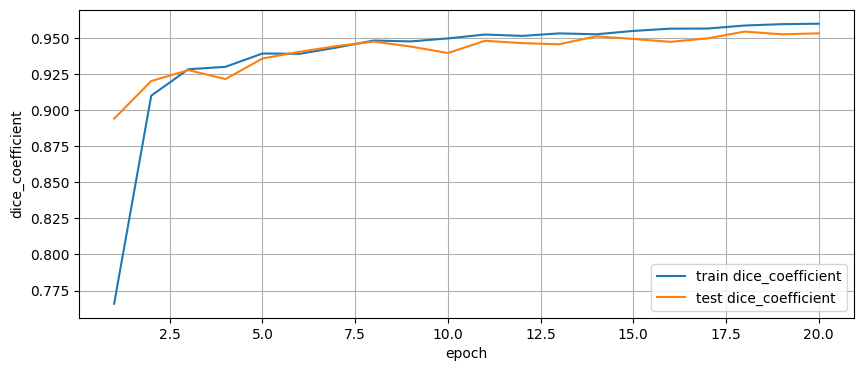


UNet model with FocalLoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.0599 - accuracy: 0.8466 - dice_coefficient: 0.7189 - jaccard_index: 0.5921 - sensitivity: 0.8663 - specificity: 0.8461 - f1_score_metric: 0.7179 - hausdorff_distance: 19.0345 - miou_metric: 0.5947 ] [ val_loss: 0.0576 - val_accuracy: 0.9663 - val_dice_coefficient: 0.8941 - val_jaccard_index: 0.8019 - val_sensitivity: 0.8788 - val_specificity: 0.9845 - val_f1_score_metric: 0.8949 - val_hausdorff_distance: 2.2269 - val_miou_metric: 0.8099 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0573 - accuracy: 0.9696 - dice_coefficient: 0.9074 - jaccard_index: 0.8250 - sensitivity: 0.8966 - specificity: 0.9858 - f1_score_metric: 0.9077 - hausdorff_distance: 2.0585 - miou_metric: 0.8313 ] [ val_loss: 0.0572 - val_accuracy: 0.9748 - val_dice_coefficient: 0.9225 - val_jaccard_index: 0.8492 - val_sensitivity: 0.9057 - val_specificity: 0.9897 - val_f1_score_metric: 0.9233 - val_hausdorff_dis

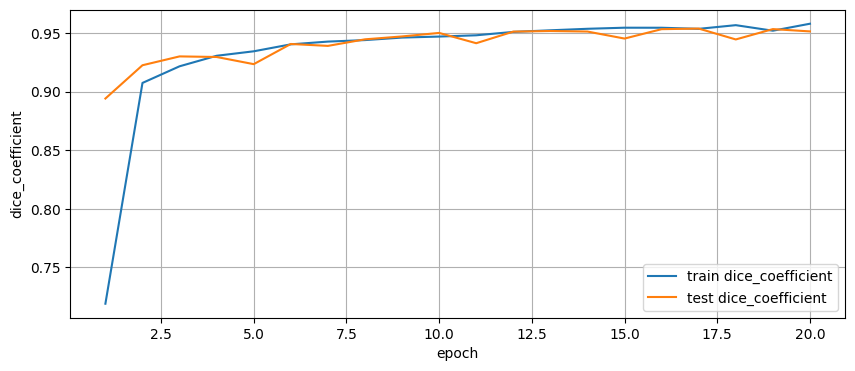


ResNet model with FocalLoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.0587 - accuracy: 0.9387 - dice_coefficient: 0.8277 - jaccard_index: 0.7243 - sensitivity: 0.8322 - specificity: 0.9611 - f1_score_metric: 0.8272 - hausdorff_distance: 6.1759 - miou_metric: 0.7283 ] [ val_loss: 0.0575 - val_accuracy: 0.9707 - val_dice_coefficient: 0.9104 - val_jaccard_index: 0.8303 - val_sensitivity: 0.9127 - val_specificity: 0.9836 - val_f1_score_metric: 0.9095 - val_hausdorff_distance: 1.7595 - val_miou_metric: 0.8341 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0571 - accuracy: 0.9748 - dice_coefficient: 0.9257 - jaccard_index: 0.8568 - sensitivity: 0.9333 - specificity: 0.9851 - f1_score_metric: 0.9247 - hausdorff_distance: 1.3539 - miou_metric: 0.8601 ] [ val_loss: 0.0570 - val_accuracy: 0.9782 - val_dice_coefficient: 0.9358 - val_jaccard_index: 0.8741 - val_sensitivity: 0.9441 - val_specificity: 0.9869 - val_f1_score_metric: 0.9343 - val_hausdorff_di

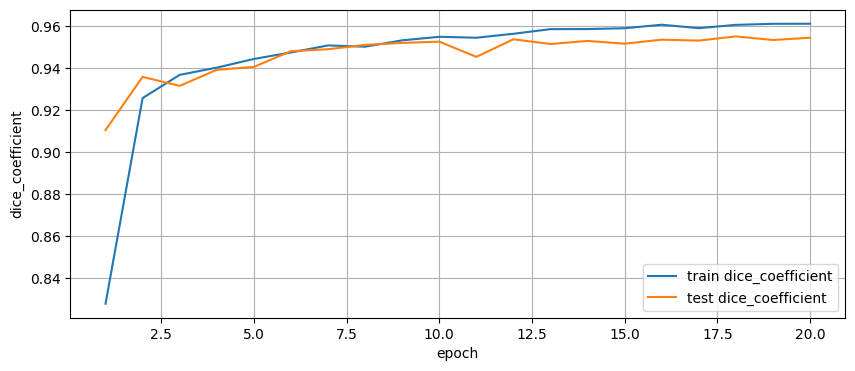


UNet model with DiceLoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6380 - accuracy: 0.8723 - dice_coefficient: 0.7388 - jaccard_index: 0.6057 - sensitivity: 0.9526 - specificity: 0.8601 - f1_score_metric: 0.7345 - hausdorff_distance: 23.5910 - miou_metric: 0.6011 ] [ val_loss: 0.6214 - val_accuracy: 0.9458 - val_dice_coefficient: 0.8506 - val_jaccard_index: 0.7391 - val_sensitivity: 0.9817 - val_specificity: 0.9419 - val_f1_score_metric: 0.8452 - val_hausdorff_distance: 5.1054 - val_miou_metric: 0.7322 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.6094 - accuracy: 0.9599 - dice_coefficient: 0.8883 - jaccard_index: 0.7982 - sensitivity: 0.9807 - specificity: 0.9587 - f1_score_metric: 0.8836 - hausdorff_distance: 2.6712 - miou_metric: 0.7923 ] [ val_loss: 0.6135 - val_accuracy: 0.9640 - val_dice_coefficient: 0.8975 - val_jaccard_index: 0.8126 - val_sensitivity: 0.9834 - val_specificity: 0.9631 - val_f1_score_metric: 0.8924 - val_hausdorff_dist

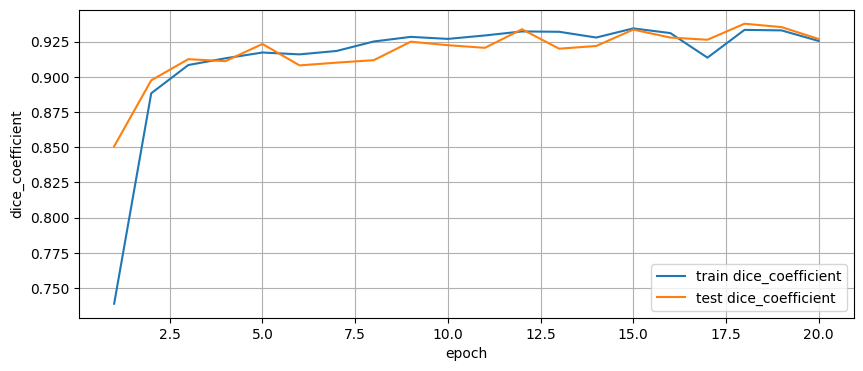


ResNet model with DiceLoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6328 - accuracy: 0.8954 - dice_coefficient: 0.7683 - jaccard_index: 0.6443 - sensitivity: 0.9434 - specificity: 0.8893 - f1_score_metric: 0.7640 - hausdorff_distance: 12.5823 - miou_metric: 0.6394 ] [ val_loss: 0.6219 - val_accuracy: 0.9560 - val_dice_coefficient: 0.8763 - val_jaccard_index: 0.7788 - val_sensitivity: 0.9825 - val_specificity: 0.9538 - val_f1_score_metric: 0.8711 - val_hausdorff_distance: 2.7332 - val_miou_metric: 0.7719 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.6092 - accuracy: 0.9578 - dice_coefficient: 0.8832 - jaccard_index: 0.7902 - sensitivity: 0.9844 - specificity: 0.9555 - f1_score_metric: 0.8783 - hausdorff_distance: 2.5237 - miou_metric: 0.7837 ] [ val_loss: 0.6135 - val_accuracy: 0.9536 - val_dice_coefficient: 0.8709 - val_jaccard_index: 0.7707 - val_sensitivity: 0.9907 - val_specificity: 0.9494 - val_f1_score_metric: 0.8650 - val_hausdorff_di

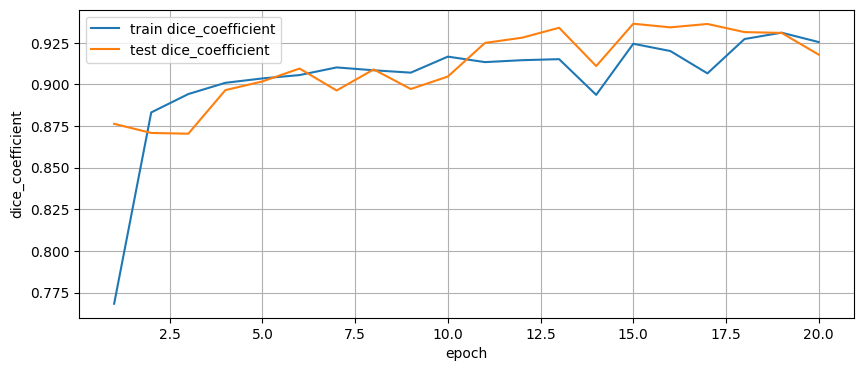


UNet model with DiceBCELoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6514 - accuracy: 0.8595 - dice_coefficient: 0.7302 - jaccard_index: 0.6029 - sensitivity: 0.9002 - specificity: 0.8550 - f1_score_metric: 0.7280 - hausdorff_distance: 18.1853 - miou_metric: 0.6027 ] [ val_loss: 0.6260 - val_accuracy: 0.9538 - val_dice_coefficient: 0.8668 - val_jaccard_index: 0.7623 - val_sensitivity: 0.9494 - val_specificity: 0.9572 - val_f1_score_metric: 0.8636 - val_hausdorff_distance: 3.1447 - val_miou_metric: 0.7603 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.6189 - accuracy: 0.9677 - dice_coefficient: 0.9064 - jaccard_index: 0.8257 - sensitivity: 0.9482 - specificity: 0.9740 - f1_score_metric: 0.9040 - hausdorff_distance: 1.9996 - miou_metric: 0.8255 ] [ val_loss: 0.6185 - val_accuracy: 0.9700 - val_dice_coefficient: 0.9127 - val_jaccard_index: 0.8364 - val_sensitivity: 0.9631 - val_specificity: 0.9738 - val_f1_score_metric: 0.9092 - val_hausdorff_d

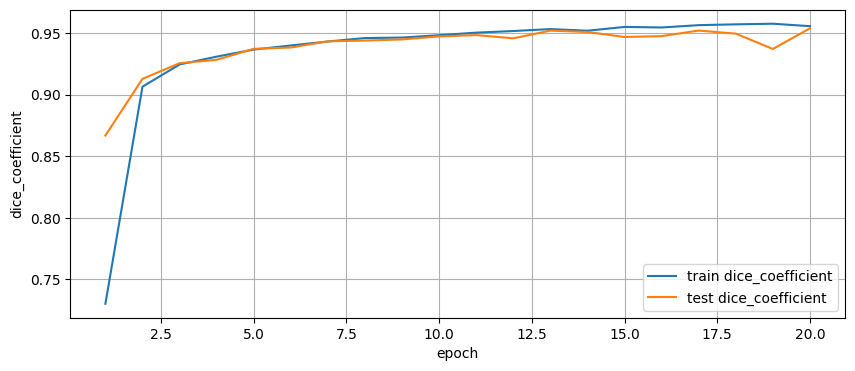


ResNet model with DiceBCELoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6529 - accuracy: 0.9050 - dice_coefficient: 0.7728 - jaccard_index: 0.6552 - sensitivity: 0.8728 - specificity: 0.9135 - f1_score_metric: 0.7701 - hausdorff_distance: 11.7508 - miou_metric: 0.6536 ] [ val_loss: 0.6499 - val_accuracy: 0.9674 - val_dice_coefficient: 0.8952 - val_jaccard_index: 0.8035 - val_sensitivity: 0.8600 - val_specificity: 0.9891 - val_f1_score_metric: 0.8962 - val_hausdorff_distance: 2.1019 - val_miou_metric: 0.8121 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.6210 - accuracy: 0.9640 - dice_coefficient: 0.8969 - jaccard_index: 0.8109 - sensitivity: 0.9586 - specificity: 0.9677 - f1_score_metric: 0.8937 - hausdorff_distance: 2.1011 - miou_metric: 0.8083 ] [ val_loss: 0.6236 - val_accuracy: 0.9687 - val_dice_coefficient: 0.9092 - val_jaccard_index: 0.8304 - val_sensitivity: 0.9630 - val_specificity: 0.9723 - val_f1_score_metric: 0.9058 - val_hausdorff

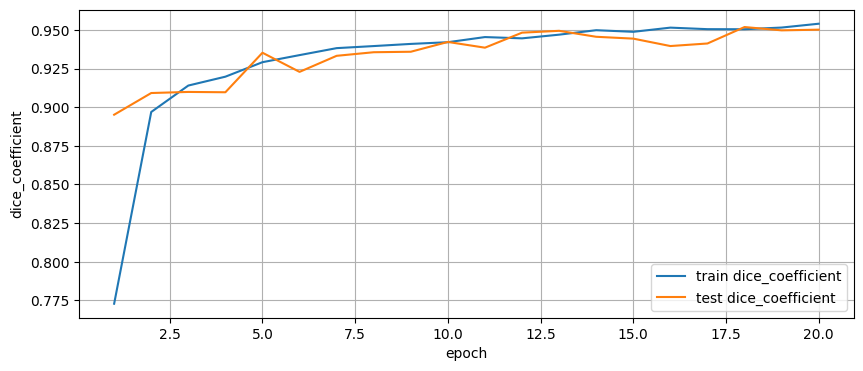


UNet model with HybridLoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.5800 - accuracy: 0.8857 - dice_coefficient: 0.7841 - jaccard_index: 0.6769 - sensitivity: 0.8684 - specificity: 0.8915 - f1_score_metric: 0.7829 - hausdorff_distance: 10.5006 - miou_metric: 0.6792 ] [ val_loss: 0.5593 - val_accuracy: 0.9708 - val_dice_coefficient: 0.9126 - val_jaccard_index: 0.8345 - val_sensitivity: 0.9316 - val_specificity: 0.9805 - val_f1_score_metric: 0.9110 - val_hausdorff_distance: 1.7513 - val_miou_metric: 0.8366 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.5544 - accuracy: 0.9734 - dice_coefficient: 0.9222 - jaccard_index: 0.8512 - sensitivity: 0.9373 - specificity: 0.9828 - f1_score_metric: 0.9207 - hausdorff_distance: 1.4305 - miou_metric: 0.8533 ] [ val_loss: 0.5545 - val_accuracy: 0.9758 - val_dice_coefficient: 0.9273 - val_jaccard_index: 0.8586 - val_sensitivity: 0.9296 - val_specificity: 0.9865 - val_f1_score_metric: 0.9266 - val_hausdorff_di

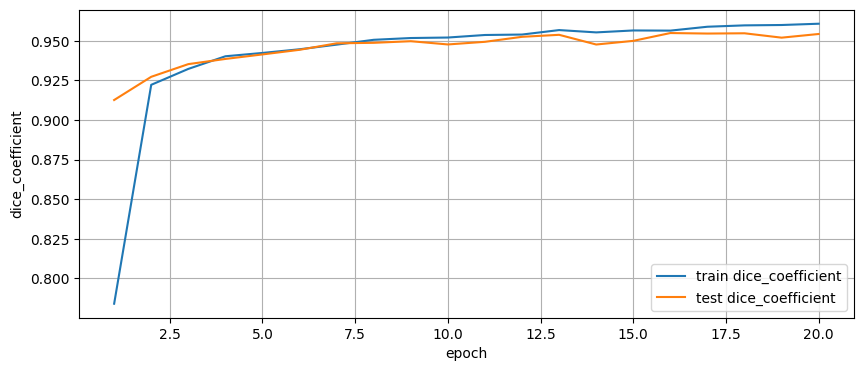


ResNet model with HybridLoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 0.6114 - accuracy: 0.8874 - dice_coefficient: 0.7330 - jaccard_index: 0.6098 - sensitivity: 0.8220 - specificity: 0.9021 - f1_score_metric: 0.7321 - hausdorff_distance: 15.8084 - miou_metric: 0.6126 ] [ val_loss: 0.5640 - val_accuracy: 0.9628 - val_dice_coefficient: 0.8760 - val_jaccard_index: 0.7717 - val_sensitivity: 0.8176 - val_specificity: 0.9914 - val_f1_score_metric: 0.8787 - val_hausdorff_distance: 2.5132 - val_miou_metric: 0.7839 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.5562 - accuracy: 0.9705 - dice_coefficient: 0.9112 - jaccard_index: 0.8316 - sensitivity: 0.9091 - specificity: 0.9846 - f1_score_metric: 0.9111 - hausdorff_distance: 1.8909 - miou_metric: 0.8370 ] [ val_loss: 0.5561 - val_accuracy: 0.9733 - val_dice_coefficient: 0.9191 - val_jaccard_index: 0.8449 - val_sensitivity: 0.9235 - val_specificity: 0.9848 - val_f1_score_metric: 0.9180 - val_hausdorff_

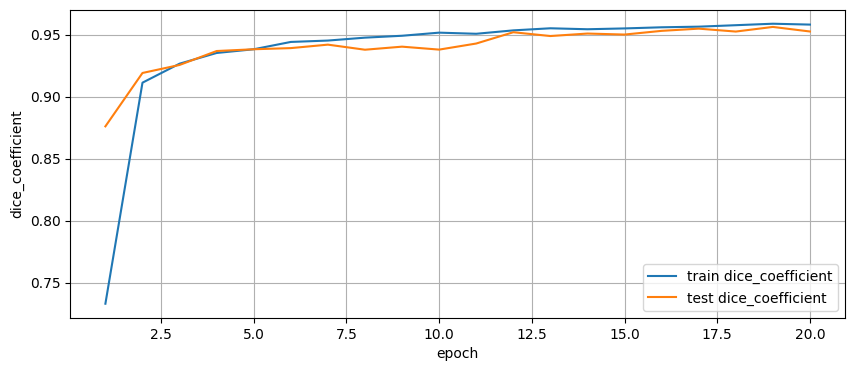


UNet model with BinaryLovaszLoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 1.3266 - accuracy: 0.9227 - dice_coefficient: 0.7753 - jaccard_index: 0.6535 - sensitivity: 0.7235 - specificity: 0.9623 - f1_score_metric: 0.7775 - hausdorff_distance: 8.6598 - miou_metric: 0.6631 ] [ val_loss: 1.3089 - val_accuracy: 0.9568 - val_dice_coefficient: 0.8461 - val_jaccard_index: 0.7250 - val_sensitivity: 0.7464 - val_specificity: 0.9968 - val_f1_score_metric: 0.8500 - val_hausdorff_distance: 3.2963 - val_miou_metric: 0.7394 ]
Epoch: 2/20    Batch: 85/85   [ loss: 1.2991 - accuracy: 0.9676 - dice_coefficient: 0.8957 - jaccard_index: 0.8038 - sensitivity: 0.8388 - specificity: 0.9941 - f1_score_metric: 0.8983 - hausdorff_distance: 2.2540 - miou_metric: 0.8158 ] [ val_loss: 1.3038 - val_accuracy: 0.9685 - val_dice_coefficient: 0.8959 - val_jaccard_index: 0.8030 - val_sensitivity: 0.8337 - val_specificity: 0.9951 - val_f1_score_metric: 0.8988 - val_hausdor

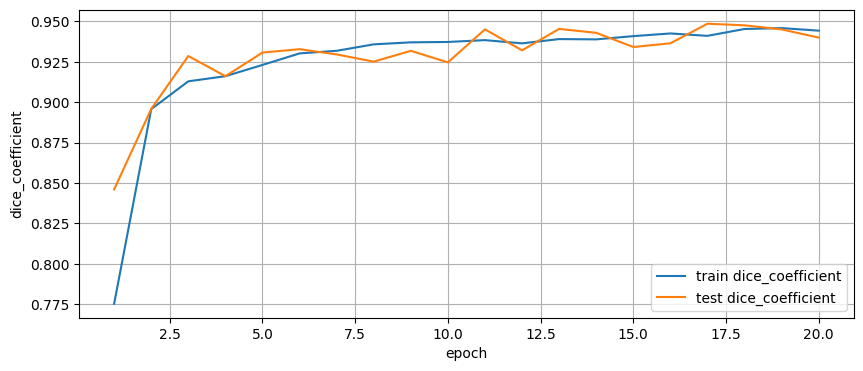


ResNet model with BinaryLovaszLoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 1.3631 - accuracy: 0.4899 - dice_coefficient: 0.4030 - jaccard_index: 0.2649 - sensitivity: 0.9209 - specificity: 0.4146 - f1_score_metric: 0.4003 - hausdorff_distance: 35.2971 - miou_metric: 0.2635 ] [ val_loss: 1.3489 - val_accuracy: 0.9134 - val_dice_coefficient: 0.7330 - val_jaccard_index: 0.5750 - val_sensitivity: 0.7675 - val_specificity: 0.9421 - val_f1_score_metric: 0.7330 - val_hausdorff_distance: 26.3868 - val_miou_metric: 0.5789 ]
Epoch: 2/20    Batch: 85/85   [ loss: 1.3433 - accuracy: 0.9251 - dice_coefficient: 0.7821 - jaccard_index: 0.6410 - sensitivity: 0.8077 - specificity: 0.9493 - f1_score_metric: 0.7826 - hausdorff_distance: 17.5064 - miou_metric: 0.6463 ] [ val_loss: 1.3450 - val_accuracy: 0.9205 - val_dice_coefficient: 0.7647 - val_jaccard_index: 0.6153 - val_sensitivity: 0.8321 - val_specificity: 0.9389 - val_f1_score_metric: 0.7646 - val_ha

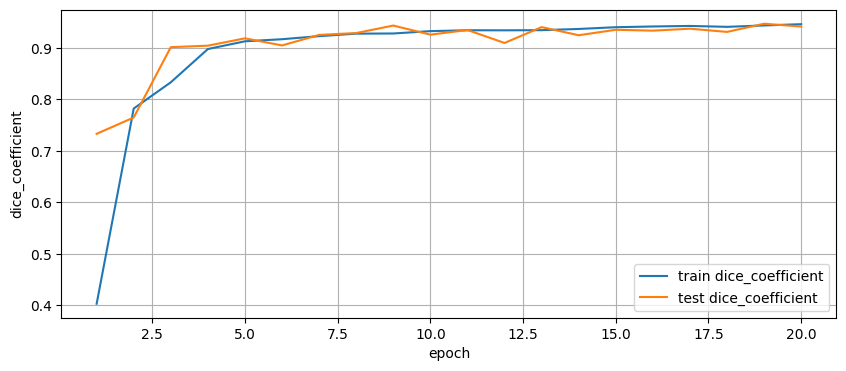


UNet model with LovaszBCELoss

FLOPs: 33.91 MFLOPs
Number of Parameters: 0.05 M
Epoch: 1/20    Batch: 85/85   [ loss: 1.9698 - accuracy: 0.9184 - dice_coefficient: 0.7903 - jaccard_index: 0.6736 - sensitivity: 0.7813 - specificity: 0.9466 - f1_score_metric: 0.7915 - hausdorff_distance: 7.8022 - miou_metric: 0.6813 ] [ val_loss: 1.9379 - val_accuracy: 0.9659 - val_dice_coefficient: 0.8865 - val_jaccard_index: 0.7880 - val_sensitivity: 0.8227 - val_specificity: 0.9941 - val_f1_score_metric: 0.8891 - val_hausdorff_distance: 2.2599 - val_miou_metric: 0.8004 ]
Epoch: 2/20    Batch: 85/85   [ loss: 1.9193 - accuracy: 0.9706 - dice_coefficient: 0.9086 - jaccard_index: 0.8258 - sensitivity: 0.8729 - specificity: 0.9915 - f1_score_metric: 0.9101 - hausdorff_distance: 1.8926 - miou_metric: 0.8354 ] [ val_loss: 1.9212 - val_accuracy: 0.9748 - val_dice_coefficient: 0.9210 - val_jaccard_index: 0.8461 - val_sensitivity: 0.8885 - val_specificity: 0.9927 - val_f1_score_metric: 0.9224 - val_hausdorff_

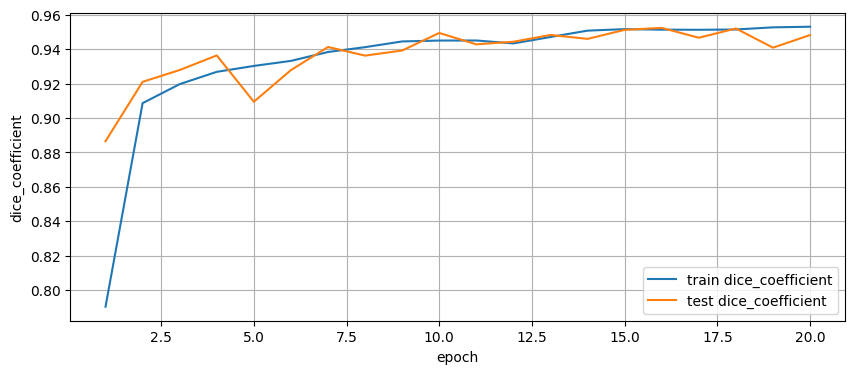


ResNet model with LovaszBCELoss

FLOPs: 36.29 MFLOPs
Number of Parameters: 0.06 M
Epoch: 1/20    Batch: 85/85   [ loss: 1.9638 - accuracy: 0.9223 - dice_coefficient: 0.8175 - jaccard_index: 0.7047 - sensitivity: 0.8531 - specificity: 0.9380 - f1_score_metric: 0.8177 - hausdorff_distance: 8.2975 - miou_metric: 0.7105 ] [ val_loss: 1.9367 - val_accuracy: 0.9627 - val_dice_coefficient: 0.8787 - val_jaccard_index: 0.7773 - val_sensitivity: 0.8416 - val_specificity: 0.9870 - val_f1_score_metric: 0.8795 - val_hausdorff_distance: 2.6085 - val_miou_metric: 0.7851 ]
Epoch: 2/20    Batch: 85/85   [ loss: 1.9203 - accuracy: 0.9693 - dice_coefficient: 0.9043 - jaccard_index: 0.8189 - sensitivity: 0.8718 - specificity: 0.9900 - f1_score_metric: 0.9056 - hausdorff_distance: 2.0428 - miou_metric: 0.8278 ] [ val_loss: 1.9301 - val_accuracy: 0.9697 - val_dice_coefficient: 0.9074 - val_jaccard_index: 0.8253 - val_sensitivity: 0.9132 - val_specificity: 0.9823 - val_f1_score_metric: 0.9063 - val_hausdorf

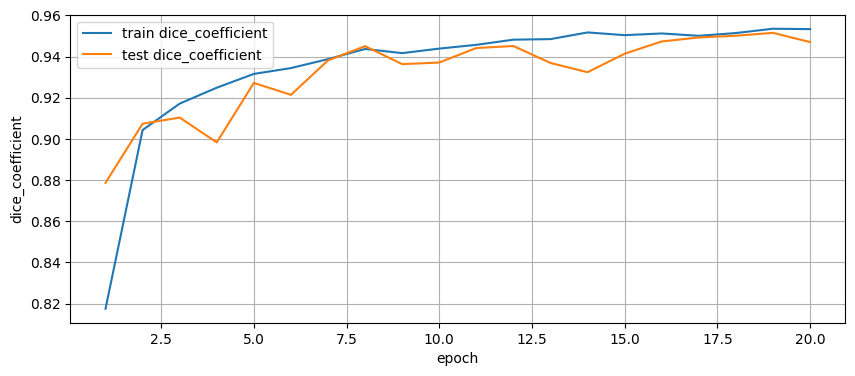

In [ ]:
models.clear()
base_models_names.clear()
base_accuracies.clear()

criterions = [
    nn.MSELoss(),
    nn.BCELoss(),
    FocalLoss(),
    DiceLoss(),
    DiceBCELoss(),
    HybridLoss(),
    BinaryLovaszLoss(),
    LovaszBCELoss(),
]

for criterion in criterions:
    print('=' * 100)
    print(f"UNet model with {criterion.__class__.__name__}")
    print()
    check_loss('UNet', criterion)
    print()

    print('=' * 100)
    print(f"ResNet model with {criterion.__class__.__name__}")
    print()
    check_loss('ResNet', criterion)
    print()

In [ ]:
result = list(zip(models, base_models_names, base_accuracies))
result = sorted(result, key=lambda x: x[2], reverse=True)

for item in result:
    print(f"{item[1]:<40} {item[2]:.4f}")

result = filter(lambda x: x[2] > 0.6, result)
models, base_models_names, base_accuracies = zip(*result)

UNet model with MSELoss                  0.9564
ResNet model with MSELoss                0.9553
ResNet model with FocalLoss              0.9544
UNet model with BCELoss                  0.9543
UNet model with HybridLoss               0.9543
UNet model with DiceBCELoss              0.9538
ResNet model with BCELoss                0.9533
ResNet model with HybridLoss             0.9525
UNet model with FocalLoss                0.9514
ResNet model with DiceBCELoss            0.9502
UNet model with LovaszBCELoss            0.9482
ResNet model with LovaszBCELoss          0.9471
ResNet model with BinaryLovaszLoss       0.9413
UNet model with BinaryLovaszLoss         0.9400
UNet model with DiceLoss                 0.9268
ResNet model with DiceLoss               0.9179


# Attention Models

In [17]:
import sys

sys.path.append('Image_Segmentation')

from Image_Segmentation.network import AttU_Net
from Image_Segmentation.network import R2AttU_Net


sys.path.append('Dual_Cross_Attention')

from Dual_Cross_Attention.model.unet import Unet
from Dual_Cross_Attention.model.vnet import Vnet
from Dual_Cross_Attention.model.res_unet_plus import ResUnetPlus
from Dual_Cross_Attention.model.r2_unet import R2Unet
from Dual_Cross_Attention.model.double_unet import DoubleUnet
from Dual_Cross_Attention.model.multi_res_unet import MultiResUnet
from Dual_Cross_Attention.model.unext import UNext
from Dual_Cross_Attention.model.transunet import TransUNet
from Dual_Cross_Attention.model.swin_unet import SwinUnet

In [18]:
input_size = (image_size, image_size)

class AttentionModel(nn.Module):
    def __init__(self, base_model):
        super(AttentionModel, self).__init__()
        self.base_model = base_model

    def forward(self, x):
        output = self.base_model(x)
        return F.sigmoid(output)


attention_models = [
    AttentionModel(AttU_Net     (img_ch=1, output_ch=1)),
    AttentionModel(R2AttU_Net   (img_ch=1, output_ch=1)),
    AttentionModel(Unet         (attention=True, in_features=1, out_features=1, input_size=input_size, device=None)),
    AttentionModel(Vnet         (attention=True, in_features=1, out_features=1, input_size=input_size, device=None)),
    AttentionModel(ResUnetPlus  (attention=True, in_features=1, out_features=1, input_size=input_size, device=None)),
    AttentionModel(R2Unet       (attention=True, in_features=1, out_features=1, input_size=input_size, device=None)),
    AttentionModel(MultiResUnet (attention=True, in_features=1, out_features=1, input_size=input_size, device=None)),
]

In [19]:
epochs = 20

attention_models_names = []
attention_accuracies = []

def check_attention_model(model, criterion):

    model_fit = ModelFit(model, criterion)
    history = model_fit.fit(train_loader=train_loader, test_loader=test_loader, epochs=epochs)

    name = f"{model.base_model.__class__.__name__} model with {criterion.__class__.__name__}"
    attention_models_names.append(name)
    attention_accuracies.append(history['val_dice_coefficient'][-1])

    plot_metric(history, 'dice_coefficient')

    for i in range(0):
        print()
        check(model, i)


AttU_Net model with MSELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0658 - accuracy: 0.9362 - dice_coefficient: 0.8547 - jaccard_index: 0.7567 - sensitivity: 0.8927 - specificity: 0.9471 - f1_score_metric: 0.8536 - hausdorff_distance: 4.2643 - miou_metric: 0.7595 ] [ val_loss: 0.0330 - val_accuracy: 0.9694 - val_dice_coefficient: 0.9069 - val_jaccard_index: 0.8222 - val_sensitivity: 0.8685 - val_specificity: 0.9913 - val_f1_score_metric: 0.9087 - val_hausdorff_distance: 2.1223 - val_miou_metric: 0.8328 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0219 - accuracy: 0.9733 - dice_coefficient: 0.9198 - jaccard_index: 0.8464 - sensitivity: 0.9232 - specificity: 0.9851 - f1_score_metric: 0.9191 - hausdorff_distance: 1.5480 - miou_metric: 0.8506 ] [ val_loss: 0.0180 - val_accuracy: 0.9758 - val_dice_coefficient: 0.9302 - val_jaccard_index: 0.8631 - val_sensitivity: 0.9192 - val_specificity: 0.9893 - val_f1_score_metric: 0.9304 - val_hausdorff_distance: 1.3355 - val_miou_metric: 0.8701 ]
Epoch: 

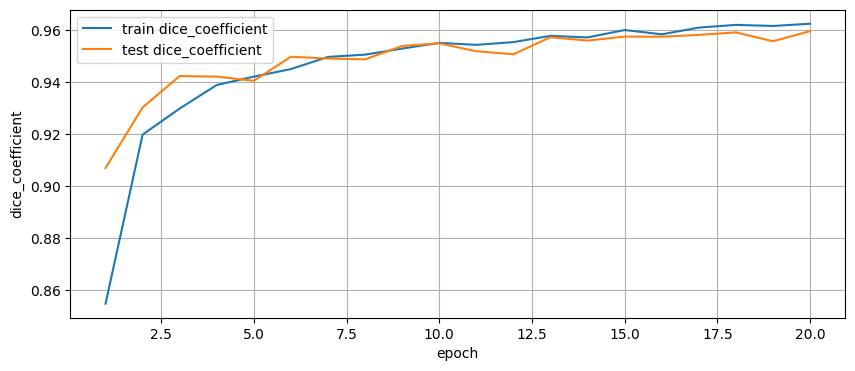


AttU_Net model with BCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0438 - accuracy: 0.9815 - dice_coefficient: 0.9459 - jaccard_index: 0.8919 - sensitivity: 0.9433 - specificity: 0.9910 - f1_score_metric: 0.9456 - hausdorff_distance: 1.1233 - miou_metric: 0.8975 ] [ val_loss: 0.0342 - val_accuracy: 0.9840 - val_dice_coefficient: 0.9564 - val_jaccard_index: 0.9092 - val_sensitivity: 0.9480 - val_specificity: 0.9935 - val_f1_score_metric: 0.9569 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9175 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0312 - accuracy: 0.9853 - dice_coefficient: 0.9586 - jaccard_index: 0.9143 - sensitivity: 0.9567 - specificity: 0.9931 - f1_score_metric: 0.9585 - hausdorff_distance: 1.0000 - miou_metric: 0.9203 ] [ val_loss: 0.0365 - val_accuracy: 0.9828 - val_dice_coefficient: 0.9533 - val_jaccard_index: 0.9053 - val_sensitivity: 0.9634 - val_specificity: 0.9892 - val_f1_score_metric: 0.9520 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9086 ]
Epoch:

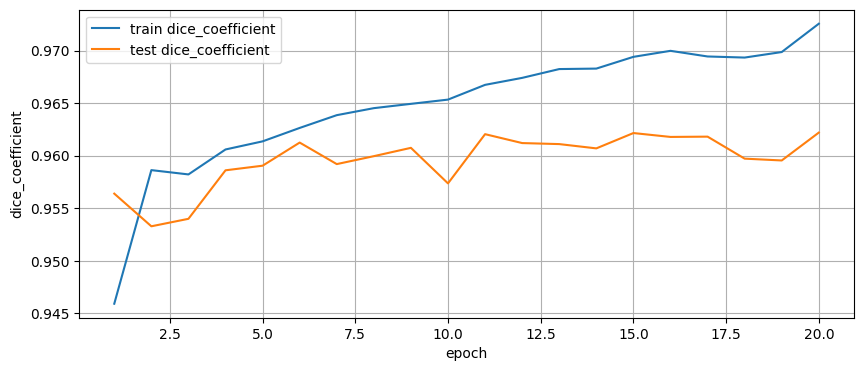


AttU_Net model with FocalLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0002 - accuracy: 0.9891 - dice_coefficient: 0.9713 - jaccard_index: 0.9377 - sensitivity: 0.9707 - specificity: 0.9950 - f1_score_metric: 0.9711 - hausdorff_distance: 1.0000 - miou_metric: 0.9438 ] [ val_loss: 0.0005 - val_accuracy: 0.9859 - val_dice_coefficient: 0.9627 - val_jaccard_index: 0.9212 - val_sensitivity: 0.9596 - val_specificity: 0.9936 - val_f1_score_metric: 0.9625 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9278 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0002 - accuracy: 0.9896 - dice_coefficient: 0.9729 - jaccard_index: 0.9407 - sensitivity: 0.9720 - specificity: 0.9953 - f1_score_metric: 0.9726 - hausdorff_distance: 0.9882 - miou_metric: 0.9467 ] [ val_loss: 0.0005 - val_accuracy: 0.9857 - val_dice_coefficient: 0.9620 - val_jaccard_index: 0.9196 - val_sensitivity: 0.9553 - val_specificity: 0.9942 - val_f1_score_metric: 0.9623 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9273 ]
Epoc

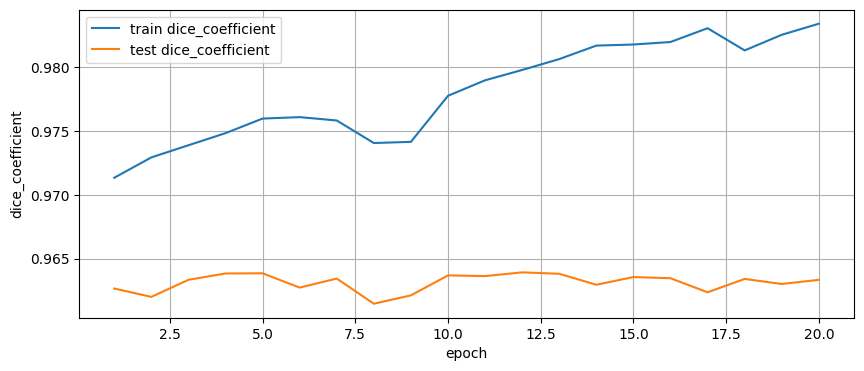


AttU_Net model with DiceLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0211 - accuracy: 0.9916 - dice_coefficient: 0.9795 - jaccard_index: 0.9532 - sensitivity: 0.9794 - specificity: 0.9964 - f1_score_metric: 0.9790 - hausdorff_distance: 0.6824 - miou_metric: 0.9589 ] [ val_loss: 0.0376 - val_accuracy: 0.9859 - val_dice_coefficient: 0.9626 - val_jaccard_index: 0.9213 - val_sensitivity: 0.9610 - val_specificity: 0.9933 - val_f1_score_metric: 0.9623 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9273 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0201 - accuracy: 0.9918 - dice_coefficient: 0.9801 - jaccard_index: 0.9544 - sensitivity: 0.9803 - specificity: 0.9964 - f1_score_metric: 0.9796 - hausdorff_distance: 0.6235 - miou_metric: 0.9599 ] [ val_loss: 0.0385 - val_accuracy: 0.9856 - val_dice_coefficient: 0.9616 - val_jaccard_index: 0.9200 - val_sensitivity: 0.9620 - val_specificity: 0.9927 - val_f1_score_metric: 0.9608 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9247 ]
Epoch

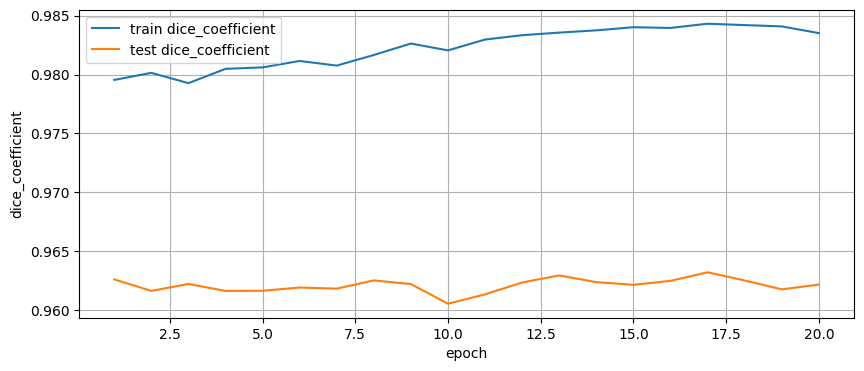


AttU_Net model with DiceBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0177 - accuracy: 0.9929 - dice_coefficient: 0.9842 - jaccard_index: 0.9623 - sensitivity: 0.9859 - specificity: 0.9969 - f1_score_metric: 0.9830 - hausdorff_distance: 0.1765 - miou_metric: 0.9666 ] [ val_loss: 0.0471 - val_accuracy: 0.9863 - val_dice_coefficient: 0.9639 - val_jaccard_index: 0.9236 - val_sensitivity: 0.9618 - val_specificity: 0.9936 - val_f1_score_metric: 0.9636 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9297 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0128 - accuracy: 0.9938 - dice_coefficient: 0.9872 - jaccard_index: 0.9676 - sensitivity: 0.9872 - specificity: 0.9977 - f1_score_metric: 0.9864 - hausdorff_distance: 0.0706 - miou_metric: 0.9731 ] [ val_loss: 0.0481 - val_accuracy: 0.9861 - val_dice_coefficient: 0.9632 - val_jaccard_index: 0.9222 - val_sensitivity: 0.9601 - val_specificity: 0.9937 - val_f1_score_metric: 0.9630 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9287 ]
Ep

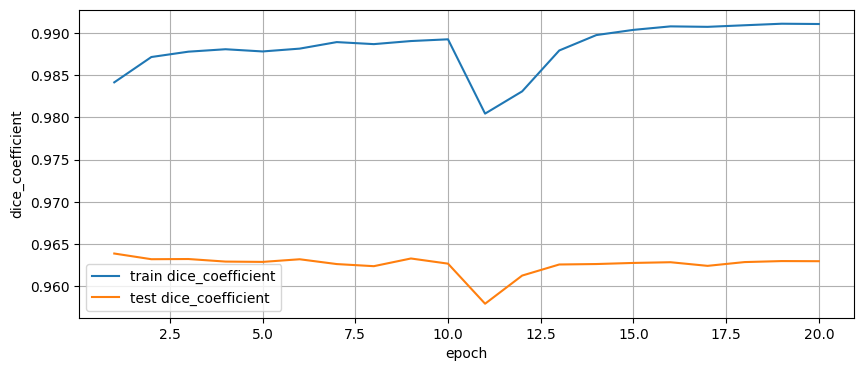


AttU_Net model with HybridLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0058 - accuracy: 0.9947 - dice_coefficient: 0.9903 - jaccard_index: 0.9735 - sensitivity: 0.9903 - specificity: 0.9983 - f1_score_metric: 0.9892 - hausdorff_distance: 0.0235 - miou_metric: 0.9787 ] [ val_loss: 0.0504 - val_accuracy: 0.9859 - val_dice_coefficient: 0.9625 - val_jaccard_index: 0.9209 - val_sensitivity: 0.9595 - val_specificity: 0.9936 - val_f1_score_metric: 0.9625 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9277 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0055 - accuracy: 0.9948 - dice_coefficient: 0.9905 - jaccard_index: 0.9738 - sensitivity: 0.9905 - specificity: 0.9983 - f1_score_metric: 0.9895 - hausdorff_distance: 0.0000 - miou_metric: 0.9791 ] [ val_loss: 0.0463 - val_accuracy: 0.9858 - val_dice_coefficient: 0.9625 - val_jaccard_index: 0.9212 - val_sensitivity: 0.9618 - val_specificity: 0.9931 - val_f1_score_metric: 0.9621 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9270 ]
Epo

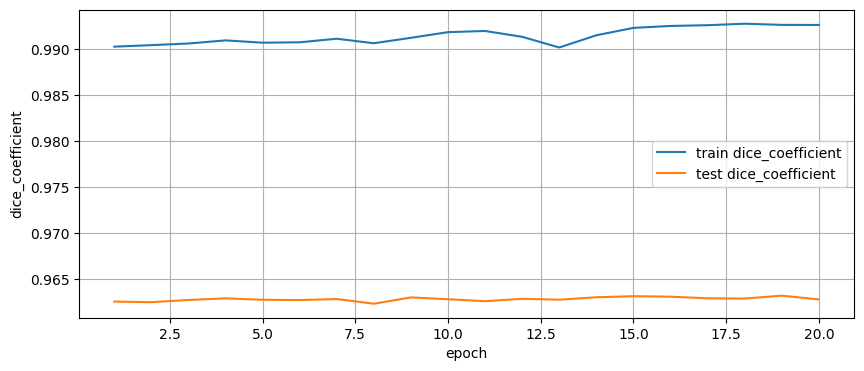


AttU_Net model with BinaryLovaszLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8517 - accuracy: 0.9941 - dice_coefficient: 0.9880 - jaccard_index: 0.9657 - sensitivity: 0.9791 - specificity: 0.9995 - f1_score_metric: 0.9909 - hausdorff_distance: 0.2235 - miou_metric: 0.9820 ] [ val_loss: 0.8716 - val_accuracy: 0.9852 - val_dice_coefficient: 0.9599 - val_jaccard_index: 0.9149 - val_sensitivity: 0.9466 - val_specificity: 0.9952 - val_f1_score_metric: 0.9612 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9253 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.8514 - accuracy: 0.9938 - dice_coefficient: 0.9870 - jaccard_index: 0.9638 - sensitivity: 0.9773 - specificity: 0.9995 - f1_score_metric: 0.9899 - hausdorff_distance: 0.2706 - miou_metric: 0.9801 ] [ val_loss: 0.8699 - val_accuracy: 0.9850 - val_dice_coefficient: 0.9593 - val_jaccard_index: 0.9135 - val_sensitivity: 0.9432 - val_specificity: 0.9956 - val_f1_score_metric: 0.9607 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9244

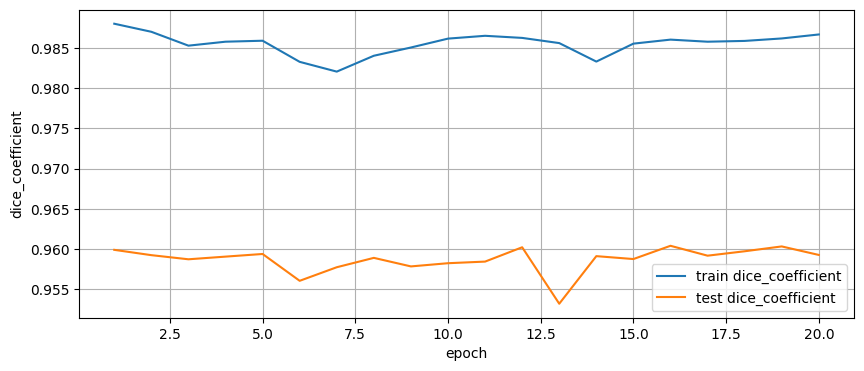


AttU_Net model with LovaszBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8683 - accuracy: 0.9945 - dice_coefficient: 0.9895 - jaccard_index: 0.9703 - sensitivity: 0.9852 - specificity: 0.9989 - f1_score_metric: 0.9901 - hausdorff_distance: 0.0118 - miou_metric: 0.9804 ] [ val_loss: 0.9504 - val_accuracy: 0.9860 - val_dice_coefficient: 0.9626 - val_jaccard_index: 0.9206 - val_sensitivity: 0.9540 - val_specificity: 0.9947 - val_f1_score_metric: 0.9632 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9291 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.8588 - accuracy: 0.9951 - dice_coefficient: 0.9917 - jaccard_index: 0.9744 - sensitivity: 0.9881 - specificity: 0.9992 - f1_score_metric: 0.9923 - hausdorff_distance: 0.0000 - miou_metric: 0.9847 ] [ val_loss: 0.9491 - val_accuracy: 0.9860 - val_dice_coefficient: 0.9627 - val_jaccard_index: 0.9206 - val_sensitivity: 0.9536 - val_specificity: 0.9948 - val_f1_score_metric: 0.9633 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9293 ]


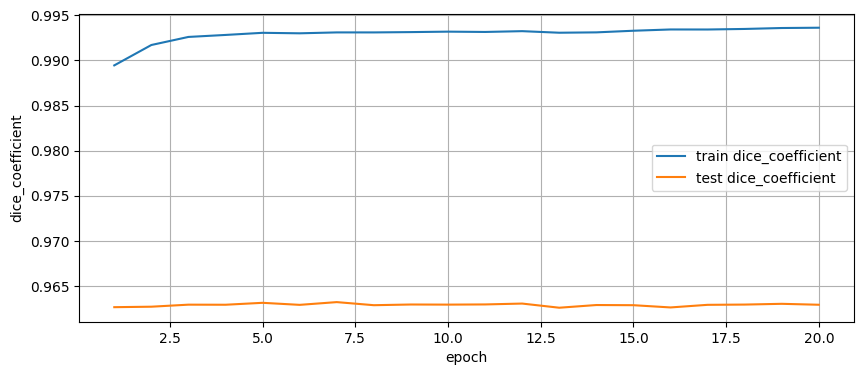


R2AttU_Net model with MSELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0410 - accuracy: 0.9417 - dice_coefficient: 0.8029 - jaccard_index: 0.6931 - sensitivity: 0.7883 - specificity: 0.9722 - f1_score_metric: 0.8029 - hausdorff_distance: 5.4857 - miou_metric: 0.6982 ] [ val_loss: 0.3125 - val_accuracy: 0.6476 - val_dice_coefficient: 0.4642 - val_jaccard_index: 0.3026 - val_sensitivity: 0.9527 - val_specificity: 0.5926 - val_f1_score_metric: 0.4598 - val_hausdorff_distance: 26.3846 - val_miou_metric: 0.2991 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0181 - accuracy: 0.9724 - dice_coefficient: 0.9155 - jaccard_index: 0.8386 - sensitivity: 0.9075 - specificity: 0.9868 - f1_score_metric: 0.9153 - hausdorff_distance: 1.7125 - miou_metric: 0.8441 ] [ val_loss: 0.2088 - val_accuracy: 0.7443 - val_dice_coefficient: 0.5488 - val_jaccard_index: 0.3787 - val_sensitivity: 0.9688 - val_specificity: 0.7046 - val_f1_score_metric: 0.5438 - val_hausdorff_distance: 20.2481 - val_miou_metric: 0.3741 ]
Ep

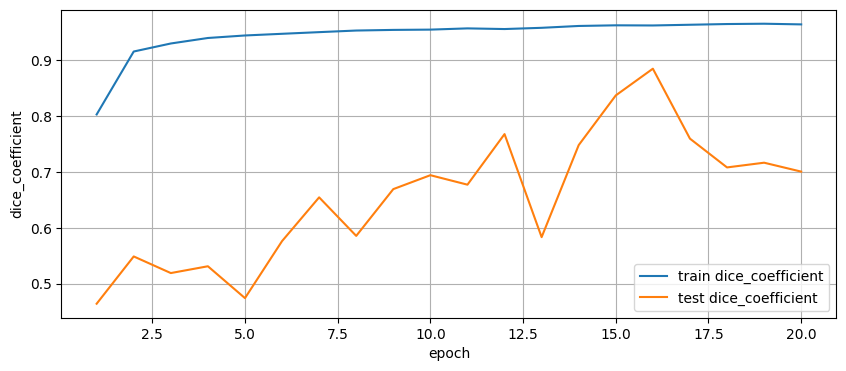


R2AttU_Net model with BCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0562 - accuracy: 0.9781 - dice_coefficient: 0.9345 - jaccard_index: 0.8731 - sensitivity: 0.9299 - specificity: 0.9895 - f1_score_metric: 0.9343 - hausdorff_distance: 1.4380 - miou_metric: 0.8787 ] [ val_loss: 0.1681 - val_accuracy: 0.9436 - val_dice_coefficient: 0.8152 - val_jaccard_index: 0.6830 - val_sensitivity: 0.7538 - val_specificity: 0.9823 - val_f1_score_metric: 0.8165 - val_hausdorff_distance: 6.3757 - val_miou_metric: 0.6907 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0330 - accuracy: 0.9843 - dice_coefficient: 0.9552 - jaccard_index: 0.9080 - sensitivity: 0.9526 - specificity: 0.9927 - f1_score_metric: 0.9550 - hausdorff_distance: 1.0097 - miou_metric: 0.9140 ] [ val_loss: 0.2339 - val_accuracy: 0.9351 - val_dice_coefficient: 0.7668 - val_jaccard_index: 0.6161 - val_sensitivity: 0.6477 - val_specificity: 0.9924 - val_f1_score_metric: 0.7696 - val_hausdorff_distance: 7.2580 - val_miou_metric: 0.6263 ]
Epoc

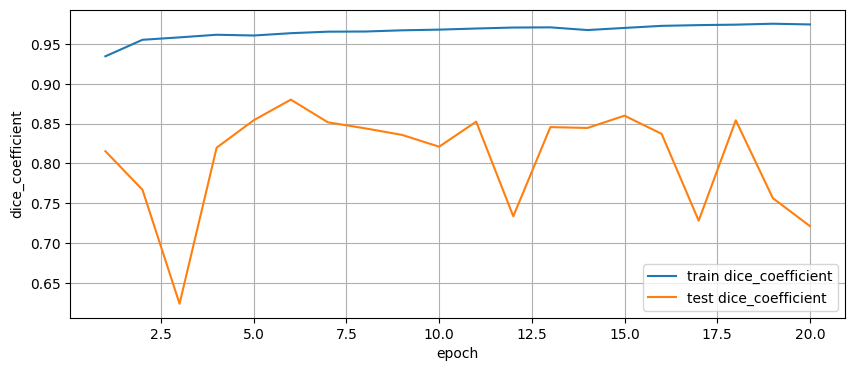


R2AttU_Net model with FocalLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0002 - accuracy: 0.9885 - dice_coefficient: 0.9694 - jaccard_index: 0.9341 - sensitivity: 0.9686 - specificity: 0.9947 - f1_score_metric: 0.9692 - hausdorff_distance: 1.0000 - miou_metric: 0.9402 ] [ val_loss: 0.0103 - val_accuracy: 0.9406 - val_dice_coefficient: 0.7938 - val_jaccard_index: 0.6520 - val_sensitivity: 0.6918 - val_specificity: 0.9905 - val_f1_score_metric: 0.7958 - val_hausdorff_distance: 4.8059 - val_miou_metric: 0.6612 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0002 - accuracy: 0.9902 - dice_coefficient: 0.9749 - jaccard_index: 0.9445 - sensitivity: 0.9746 - specificity: 0.9956 - f1_score_metric: 0.9745 - hausdorff_distance: 0.9765 - miou_metric: 0.9503 ] [ val_loss: 0.0113 - val_accuracy: 0.9414 - val_dice_coefficient: 0.7980 - val_jaccard_index: 0.6580 - val_sensitivity: 0.6984 - val_specificity: 0.9904 - val_f1_score_metric: 0.7999 - val_hausdorff_distance: 6.2576 - val_miou_metric: 0.6670 ]
Ep

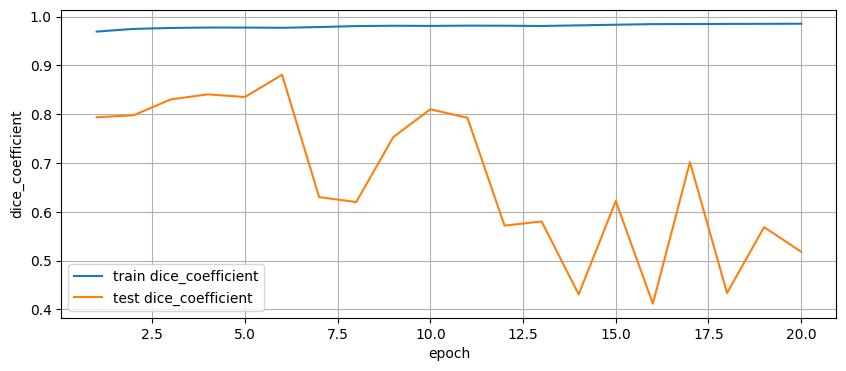


R2AttU_Net model with DiceLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0223 - accuracy: 0.9913 - dice_coefficient: 0.9785 - jaccard_index: 0.9513 - sensitivity: 0.9786 - specificity: 0.9962 - f1_score_metric: 0.9780 - hausdorff_distance: 0.8000 - miou_metric: 0.9569 ] [ val_loss: 0.7212 - val_accuracy: 0.8639 - val_dice_coefficient: 0.2793 - val_jaccard_index: 0.1618 - val_sensitivity: 0.1641 - val_specificity: 0.9998 - val_f1_score_metric: 0.2820 - val_hausdorff_distance: 17.3944 - val_miou_metric: 0.1658 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0194 - accuracy: 0.9920 - dice_coefficient: 0.9809 - jaccard_index: 0.9557 - sensitivity: 0.9809 - specificity: 0.9966 - f1_score_metric: 0.9803 - hausdorff_distance: 0.5882 - miou_metric: 0.9614 ] [ val_loss: 0.3372 - val_accuracy: 0.9164 - val_dice_coefficient: 0.6639 - val_jaccard_index: 0.4933 - val_sensitivity: 0.5086 - val_specificity: 0.9965 - val_f1_score_metric: 0.6677 - val_hausdorff_distance: 7.7890 - val_miou_metric: 0.5037 ]
Ep

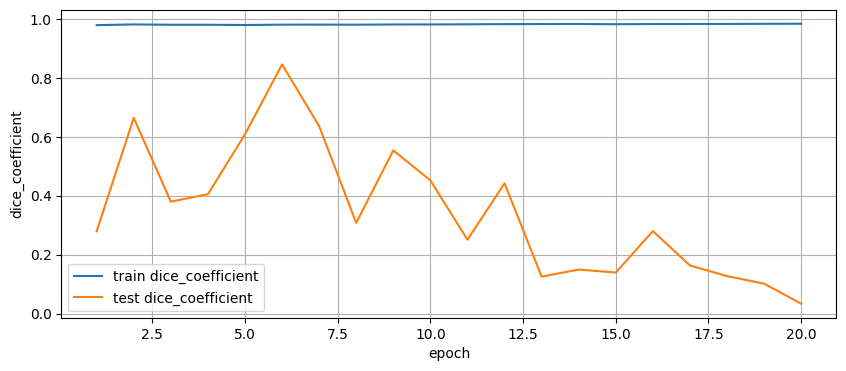


R2AttU_Net model with DiceBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0271 - accuracy: 0.9926 - dice_coefficient: 0.9830 - jaccard_index: 0.9598 - sensitivity: 0.9835 - specificity: 0.9969 - f1_score_metric: 0.9822 - hausdorff_distance: 0.3529 - miou_metric: 0.9651 ] [ val_loss: 1.4592 - val_accuracy: 0.8463 - val_dice_coefficient: 0.0958 - val_jaccard_index: 0.0501 - val_sensitivity: 0.0508 - val_specificity: 1.0000 - val_f1_score_metric: 0.0970 - val_hausdorff_distance: 25.7367 - val_miou_metric: 0.0514 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0137 - accuracy: 0.9936 - dice_coefficient: 0.9865 - jaccard_index: 0.9662 - sensitivity: 0.9864 - specificity: 0.9976 - f1_score_metric: 0.9858 - hausdorff_distance: 0.0235 - miou_metric: 0.9719 ] [ val_loss: 1.3536 - val_accuracy: 0.8508 - val_dice_coefficient: 0.1457 - val_jaccard_index: 0.0782 - val_sensitivity: 0.0793 - val_specificity: 1.0000 - val_f1_score_metric: 0.1474 - val_hausdorff_distance: 21.9310 - val_miou_metric: 0.0802 

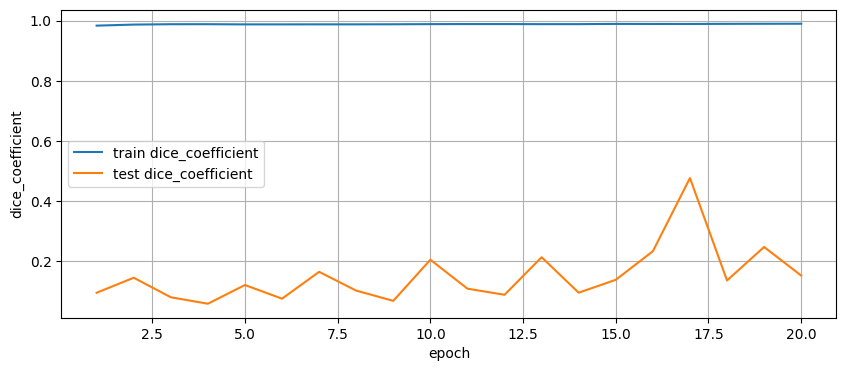


R2AttU_Net model with HybridLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0070 - accuracy: 0.9941 - dice_coefficient: 0.9881 - jaccard_index: 0.9694 - sensitivity: 0.9881 - specificity: 0.9979 - f1_score_metric: 0.9873 - hausdorff_distance: 0.0118 - miou_metric: 0.9749 ] [ val_loss: 1.7697 - val_accuracy: 0.8436 - val_dice_coefficient: 0.0645 - val_jaccard_index: 0.0332 - val_sensitivity: 0.0337 - val_specificity: 1.0000 - val_f1_score_metric: 0.0653 - val_hausdorff_distance: 31.9681 - val_miou_metric: 0.0341 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0064 - accuracy: 0.9944 - dice_coefficient: 0.9890 - jaccard_index: 0.9710 - sensitivity: 0.9889 - specificity: 0.9980 - f1_score_metric: 0.9882 - hausdorff_distance: 0.0000 - miou_metric: 0.9766 ] [ val_loss: 1.0634 - val_accuracy: 0.8606 - val_dice_coefficient: 0.2476 - val_jaccard_index: 0.1404 - val_sensitivity: 0.1425 - val_specificity: 0.9998 - val_f1_score_metric: 0.2501 - val_hausdorff_distance: 17.4139 - val_miou_metric: 0.1440 ]

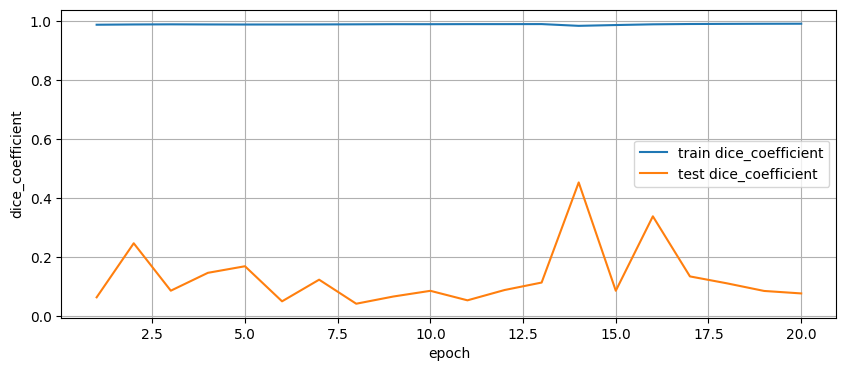


R2AttU_Net model with BinaryLovaszLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8528 - accuracy: 0.9932 - dice_coefficient: 0.9847 - jaccard_index: 0.9592 - sensitivity: 0.9729 - specificity: 0.9995 - f1_score_metric: 0.9881 - hausdorff_distance: 0.6000 - miou_metric: 0.9765 ] [ val_loss: 0.9951 - val_accuracy: 0.8432 - val_dice_coefficient: 0.0608 - val_jaccard_index: 0.0312 - val_sensitivity: 0.0316 - val_specificity: 1.0000 - val_f1_score_metric: 0.0616 - val_hausdorff_distance: 29.5555 - val_miou_metric: 0.0321 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.8540 - accuracy: 0.9920 - dice_coefficient: 0.9807 - jaccard_index: 0.9516 - sensitivity: 0.9655 - specificity: 0.9994 - f1_score_metric: 0.9842 - hausdorff_distance: 0.8706 - miou_metric: 0.9690 ] [ val_loss: 0.9992 - val_accuracy: 0.8391 - val_dice_coefficient: 0.0108 - val_jaccard_index: 0.0054 - val_sensitivity: 0.0055 - val_specificity: 1.0000 - val_f1_score_metric: 0.0110 - val_hausdorff_distance: 35.7191 - val_miou_metric: 0.

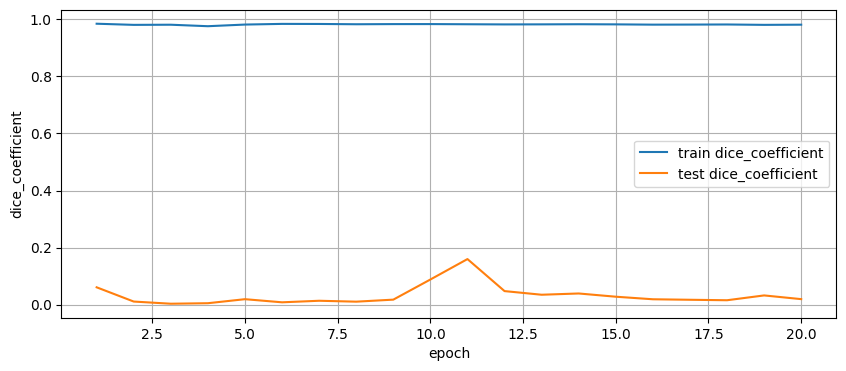


R2AttU_Net model with LovaszBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8889 - accuracy: 0.9936 - dice_coefficient: 0.9864 - jaccard_index: 0.9647 - sensitivity: 0.9817 - specificity: 0.9984 - f1_score_metric: 0.9870 - hausdorff_distance: 0.0824 - miou_metric: 0.9743 ] [ val_loss: 5.4834 - val_accuracy: 0.8386 - val_dice_coefficient: 0.0047 - val_jaccard_index: 0.0023 - val_sensitivity: 0.0024 - val_specificity: 1.0000 - val_f1_score_metric: 0.0047 - val_hausdorff_distance: 27.0151 - val_miou_metric: 0.0024 ]
Epoch: 2/20    Batch: 35/85   [ loss: 0.8615 - accuracy: 0.9944 - dice_coefficient: 0.9894 - jaccard_index: 0.9696 - sensitivity: 0.9843 - specificity: 0.9990 - f1_score_metric: 0.9904 - hausdorff_distance: 0.0286 - miou_metric: 0.9810 ]

In [ ]:
attention_models_names.clear()
attention_accuracies.clear()

criterions = [
    nn.MSELoss(),
    nn.BCELoss(),
    FocalLoss(),
    DiceLoss(),
    DiceBCELoss(),
    HybridLoss(),
    BinaryLovaszLoss(),
    LovaszBCELoss(),
]

for model in attention_models:
    for criterion in criterions:
        print('=' * 100)
        print(f"{model.base_model.__class__.__name__} model with {criterion.__class__.__name__}")
        print()
        check_attention_model(model, criterion)
        print()

Unet model with MSELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0441 - accuracy: 0.9600 - dice_coefficient: 0.8704 - jaccard_index: 0.7798 - sensitivity: 0.8724 - specificity: 0.9782 - f1_score_metric: 0.8698 - hausdorff_distance: 3.1624 - miou_metric: 0.7838 ] [ val_loss: 0.0274 - val_accuracy: 0.9666 - val_dice_coefficient: 0.9062 - val_jaccard_index: 0.8252 - val_sensitivity: 0.9501 - val_specificity: 0.9725 - val_f1_score_metric: 0.9033 - val_hausdorff_distance: 2.0353 - val_miou_metric: 0.8241 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0189 - accuracy: 0.9756 - dice_coefficient: 0.9267 - jaccard_index: 0.8578 - sensitivity: 0.9225 - specificity: 0.9879 - f1_score_metric: 0.9265 - hausdorff_distance: 1.3726 - miou_metric: 0.8632 ] [ val_loss: 0.0167 - val_accuracy: 0.9763 - val_dice_coefficient: 0.9324 - val_jaccard_index: 0.8679 - val_sensitivity: 0.9302 - val_specificity: 0.9877 - val_f1_score_metric: 0.9314 - val_hausdorff_distance: 1.2403 - val_miou_metric: 0.8718 ]
Epoch: 3/20

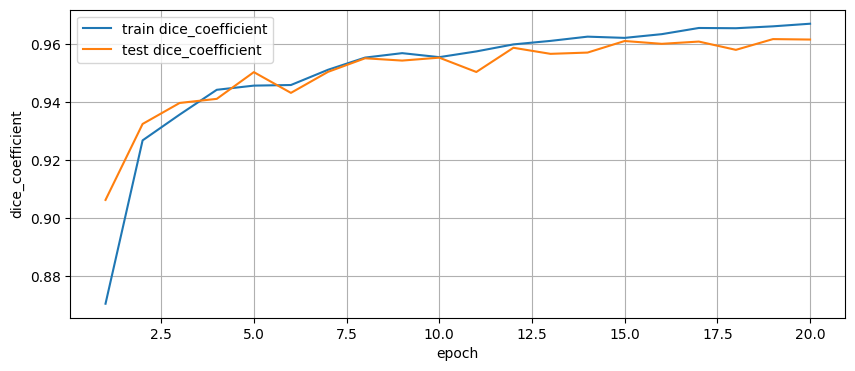


Unet model with BCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0311 - accuracy: 0.9861 - dice_coefficient: 0.9613 - jaccard_index: 0.9192 - sensitivity: 0.9596 - specificity: 0.9934 - f1_score_metric: 0.9611 - hausdorff_distance: 1.0000 - miou_metric: 0.9252 ] [ val_loss: 0.0337 - val_accuracy: 0.9845 - val_dice_coefficient: 0.9584 - val_jaccard_index: 0.9144 - val_sensitivity: 0.9622 - val_specificity: 0.9914 - val_f1_score_metric: 0.9574 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9184 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0258 - accuracy: 0.9873 - dice_coefficient: 0.9655 - jaccard_index: 0.9269 - sensitivity: 0.9641 - specificity: 0.9941 - f1_score_metric: 0.9652 - hausdorff_distance: 1.0000 - miou_metric: 0.9328 ] [ val_loss: 0.0325 - val_accuracy: 0.9847 - val_dice_coefficient: 0.9587 - val_jaccard_index: 0.9138 - val_sensitivity: 0.9524 - val_specificity: 0.9935 - val_f1_score_metric: 0.9587 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9207 ]
Epoch: 3/2

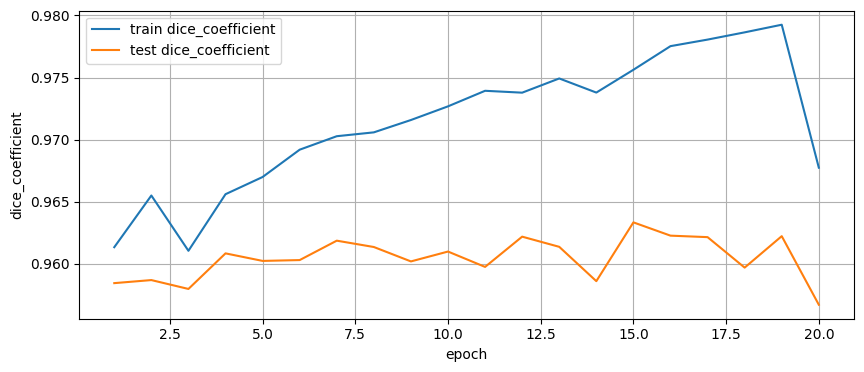


Unet model with FocalLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0002 - accuracy: 0.9892 - dice_coefficient: 0.9714 - jaccard_index: 0.9378 - sensitivity: 0.9709 - specificity: 0.9950 - f1_score_metric: 0.9711 - hausdorff_distance: 1.0000 - miou_metric: 0.9438 ] [ val_loss: 0.0005 - val_accuracy: 0.9856 - val_dice_coefficient: 0.9618 - val_jaccard_index: 0.9205 - val_sensitivity: 0.9648 - val_specificity: 0.9922 - val_f1_score_metric: 0.9609 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9247 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0001 - accuracy: 0.9911 - dice_coefficient: 0.9778 - jaccard_index: 0.9500 - sensitivity: 0.9780 - specificity: 0.9960 - f1_score_metric: 0.9773 - hausdorff_distance: 0.8824 - miou_metric: 0.9556 ] [ val_loss: 0.0006 - val_accuracy: 0.9858 - val_dice_coefficient: 0.9623 - val_jaccard_index: 0.9201 - val_sensitivity: 0.9544 - val_specificity: 0.9945 - val_f1_score_metric: 0.9627 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9281 ]
Epoch: 3

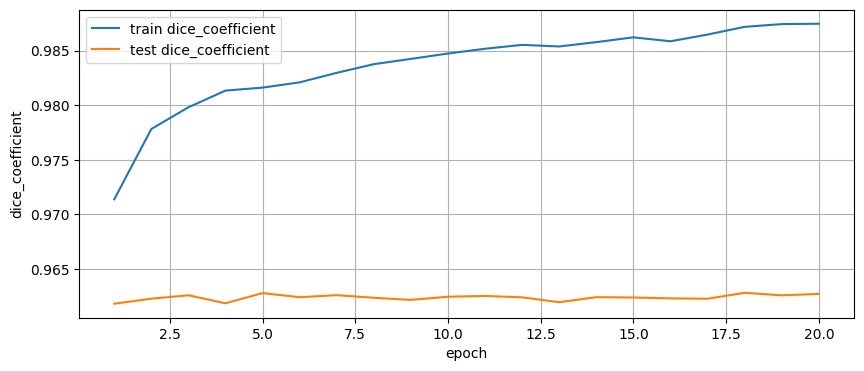


Unet model with DiceLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0166 - accuracy: 0.9930 - dice_coefficient: 0.9843 - jaccard_index: 0.9623 - sensitivity: 0.9845 - specificity: 0.9972 - f1_score_metric: 0.9836 - hausdorff_distance: 0.1647 - miou_metric: 0.9678 ] [ val_loss: 0.0393 - val_accuracy: 0.9854 - val_dice_coefficient: 0.9609 - val_jaccard_index: 0.9180 - val_sensitivity: 0.9563 - val_specificity: 0.9936 - val_f1_score_metric: 0.9609 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9247 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0159 - accuracy: 0.9930 - dice_coefficient: 0.9845 - jaccard_index: 0.9626 - sensitivity: 0.9844 - specificity: 0.9972 - f1_score_metric: 0.9838 - hausdorff_distance: 0.1294 - miou_metric: 0.9682 ] [ val_loss: 0.0394 - val_accuracy: 0.9853 - val_dice_coefficient: 0.9607 - val_jaccard_index: 0.9178 - val_sensitivity: 0.9570 - val_specificity: 0.9934 - val_f1_score_metric: 0.9604 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9240 ]
Epoch: 3/

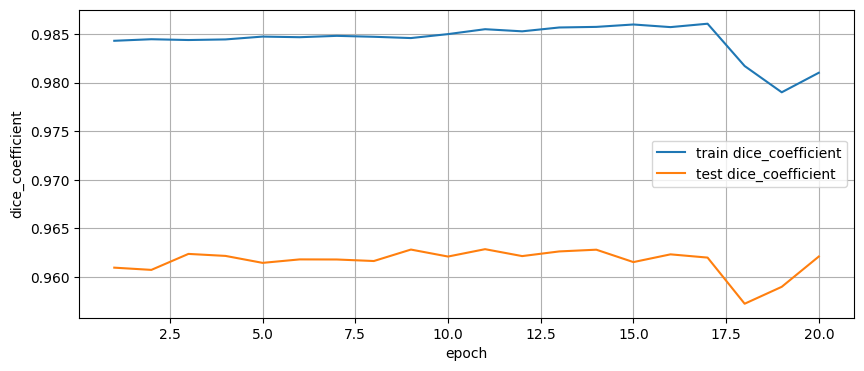


Unet model with DiceBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0175 - accuracy: 0.9930 - dice_coefficient: 0.9843 - jaccard_index: 0.9628 - sensitivity: 0.9870 - specificity: 0.9967 - f1_score_metric: 0.9829 - hausdorff_distance: 0.1412 - miou_metric: 0.9665 ] [ val_loss: 0.0505 - val_accuracy: 0.9859 - val_dice_coefficient: 0.9625 - val_jaccard_index: 0.9207 - val_sensitivity: 0.9571 - val_specificity: 0.9941 - val_f1_score_metric: 0.9626 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9279 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0132 - accuracy: 0.9937 - dice_coefficient: 0.9868 - jaccard_index: 0.9669 - sensitivity: 0.9870 - specificity: 0.9976 - f1_score_metric: 0.9859 - hausdorff_distance: 0.0588 - miou_metric: 0.9722 ] [ val_loss: 0.0509 - val_accuracy: 0.9860 - val_dice_coefficient: 0.9630 - val_jaccard_index: 0.9222 - val_sensitivity: 0.9619 - val_specificity: 0.9933 - val_f1_score_metric: 0.9625 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9278 ]
Epoch:

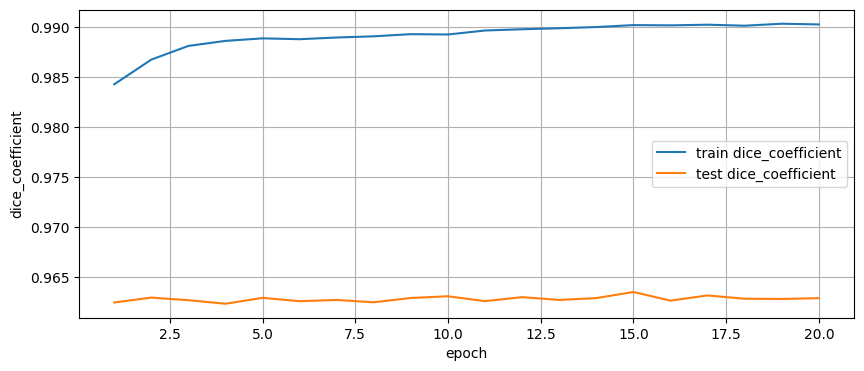


Unet model with HybridLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0061 - accuracy: 0.9946 - dice_coefficient: 0.9897 - jaccard_index: 0.9723 - sensitivity: 0.9895 - specificity: 0.9982 - f1_score_metric: 0.9888 - hausdorff_distance: 0.0235 - miou_metric: 0.9779 ] [ val_loss: 0.0491 - val_accuracy: 0.9862 - val_dice_coefficient: 0.9636 - val_jaccard_index: 0.9233 - val_sensitivity: 0.9623 - val_specificity: 0.9934 - val_f1_score_metric: 0.9631 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9288 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0054 - accuracy: 0.9948 - dice_coefficient: 0.9907 - jaccard_index: 0.9742 - sensitivity: 0.9908 - specificity: 0.9983 - f1_score_metric: 0.9896 - hausdorff_distance: 0.0000 - miou_metric: 0.9794 ] [ val_loss: 0.0481 - val_accuracy: 0.9860 - val_dice_coefficient: 0.9630 - val_jaccard_index: 0.9218 - val_sensitivity: 0.9591 - val_specificity: 0.9938 - val_f1_score_metric: 0.9629 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9285 ]
Epoch: 

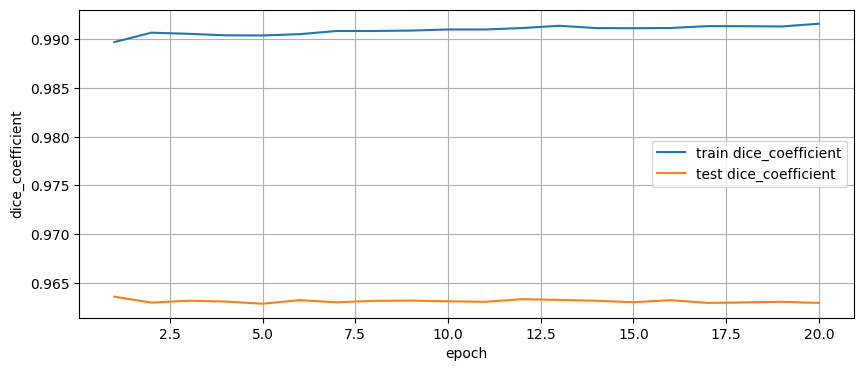


Unet model with BinaryLovaszLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8521 - accuracy: 0.9937 - dice_coefficient: 0.9866 - jaccard_index: 0.9629 - sensitivity: 0.9763 - specificity: 0.9995 - f1_score_metric: 0.9897 - hausdorff_distance: 0.3765 - miou_metric: 0.9797 ] [ val_loss: 0.8706 - val_accuracy: 0.9855 - val_dice_coefficient: 0.9611 - val_jaccard_index: 0.9173 - val_sensitivity: 0.9484 - val_specificity: 0.9953 - val_f1_score_metric: 0.9621 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9271 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.8519 - accuracy: 0.9936 - dice_coefficient: 0.9863 - jaccard_index: 0.9625 - sensitivity: 0.9760 - specificity: 0.9994 - f1_score_metric: 0.9894 - hausdorff_distance: 0.3882 - miou_metric: 0.9790 ] [ val_loss: 0.8695 - val_accuracy: 0.9855 - val_dice_coefficient: 0.9610 - val_jaccard_index: 0.9169 - val_sensitivity: 0.9466 - val_specificity: 0.9956 - val_f1_score_metric: 0.9623 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9274 ]
E

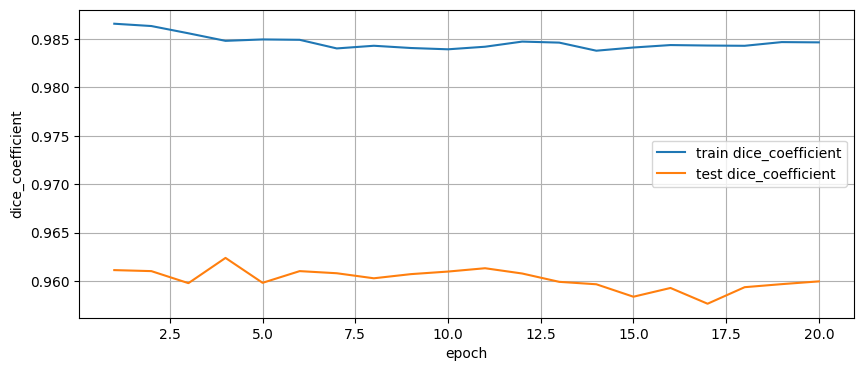


Unet model with LovaszBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8728 - accuracy: 0.9941 - dice_coefficient: 0.9882 - jaccard_index: 0.9682 - sensitivity: 0.9843 - specificity: 0.9986 - f1_score_metric: 0.9887 - hausdorff_distance: 0.0588 - miou_metric: 0.9776 ] [ val_loss: 0.9413 - val_accuracy: 0.9860 - val_dice_coefficient: 0.9629 - val_jaccard_index: 0.9211 - val_sensitivity: 0.9554 - val_specificity: 0.9946 - val_f1_score_metric: 0.9633 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9293 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.8605 - accuracy: 0.9948 - dice_coefficient: 0.9907 - jaccard_index: 0.9723 - sensitivity: 0.9864 - specificity: 0.9991 - f1_score_metric: 0.9915 - hausdorff_distance: 0.0000 - miou_metric: 0.9832 ] [ val_loss: 0.9472 - val_accuracy: 0.9861 - val_dice_coefficient: 0.9632 - val_jaccard_index: 0.9220 - val_sensitivity: 0.9571 - val_specificity: 0.9943 - val_f1_score_metric: 0.9634 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9294 ]
Epoc

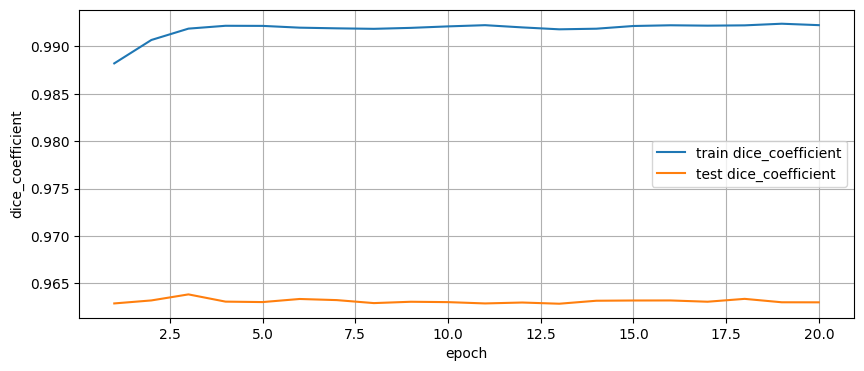

Vnet model with MSELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0799 - accuracy: 0.9390 - dice_coefficient: 0.8358 - jaccard_index: 0.7283 - sensitivity: 0.8711 - specificity: 0.9540 - f1_score_metric: 0.8343 - hausdorff_distance: 4.5161 - miou_metric: 0.7300 ] [ val_loss: 0.0425 - val_accuracy: 0.9605 - val_dice_coefficient: 0.8903 - val_jaccard_index: 0.7994 - val_sensitivity: 0.9506 - val_specificity: 0.9651 - val_f1_score_metric: 0.8871 - val_hausdorff_distance: 2.1907 - val_miou_metric: 0.7973 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0304 - accuracy: 0.9688 - dice_coefficient: 0.9051 - jaccard_index: 0.8218 - sensitivity: 0.9098 - specificity: 0.9822 - f1_score_metric: 0.9044 - hausdorff_distance: 1.8794 - miou_metric: 0.8257 ] [ val_loss: 0.0272 - val_accuracy: 0.9673 - val_dice_coefficient: 0.9012 - val_jaccard_index: 0.8133 - val_sensitivity: 0.8724 - val_specificity: 0.9881 - val_f1_score_metric: 0.9024 - val_hausdorff_distance: 2.0689 - val_miou_metric: 0.8222 ]
Epoch: 3/20

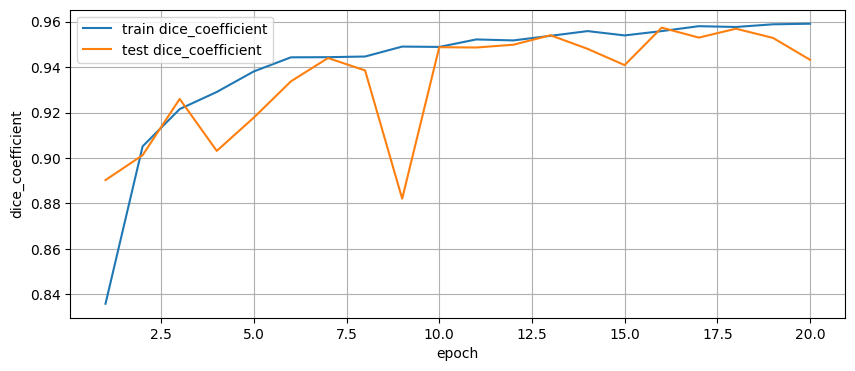


Vnet model with BCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0401 - accuracy: 0.9831 - dice_coefficient: 0.9513 - jaccard_index: 0.9008 - sensitivity: 0.9449 - specificity: 0.9926 - f1_score_metric: 0.9513 - hausdorff_distance: 1.0341 - miou_metric: 0.9073 ] [ val_loss: 0.0397 - val_accuracy: 0.9818 - val_dice_coefficient: 0.9495 - val_jaccard_index: 0.8972 - val_sensitivity: 0.9438 - val_specificity: 0.9917 - val_f1_score_metric: 0.9495 - val_hausdorff_distance: 1.0079 - val_miou_metric: 0.9039 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0333 - accuracy: 0.9846 - dice_coefficient: 0.9565 - jaccard_index: 0.9102 - sensitivity: 0.9518 - specificity: 0.9932 - f1_score_metric: 0.9565 - hausdorff_distance: 1.0000 - miou_metric: 0.9166 ] [ val_loss: 0.0347 - val_accuracy: 0.9838 - val_dice_coefficient: 0.9557 - val_jaccard_index: 0.9085 - val_sensitivity: 0.9515 - val_specificity: 0.9926 - val_f1_score_metric: 0.9556 - val_hausdorff_distance: 1.0197 - val_miou_metric: 0.9150 ]
Epoch: 3/2

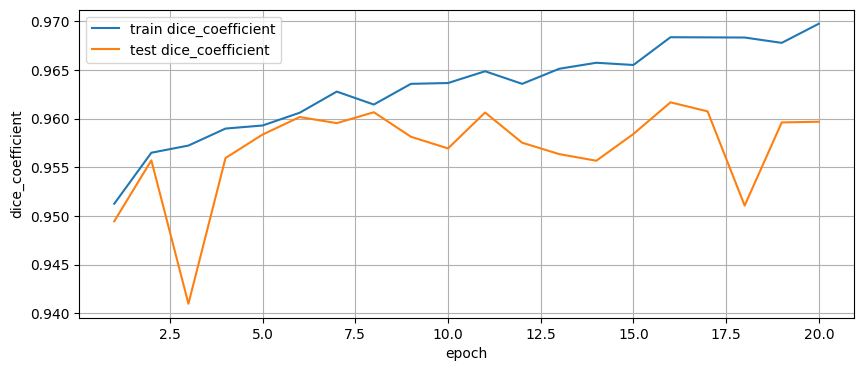


Vnet model with FocalLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0003 - accuracy: 0.9881 - dice_coefficient: 0.9680 - jaccard_index: 0.9316 - sensitivity: 0.9668 - specificity: 0.9945 - f1_score_metric: 0.9677 - hausdorff_distance: 1.0000 - miou_metric: 0.9375 ] [ val_loss: 0.0005 - val_accuracy: 0.9850 - val_dice_coefficient: 0.9594 - val_jaccard_index: 0.9144 - val_sensitivity: 0.9480 - val_specificity: 0.9947 - val_f1_score_metric: 0.9603 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9237 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0002 - accuracy: 0.9888 - dice_coefficient: 0.9704 - jaccard_index: 0.9361 - sensitivity: 0.9697 - specificity: 0.9949 - f1_score_metric: 0.9701 - hausdorff_distance: 1.0000 - miou_metric: 0.9420 ] [ val_loss: 0.0005 - val_accuracy: 0.9848 - val_dice_coefficient: 0.9588 - val_jaccard_index: 0.9137 - val_sensitivity: 0.9514 - val_specificity: 0.9937 - val_f1_score_metric: 0.9591 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9214 ]
Epoch: 3

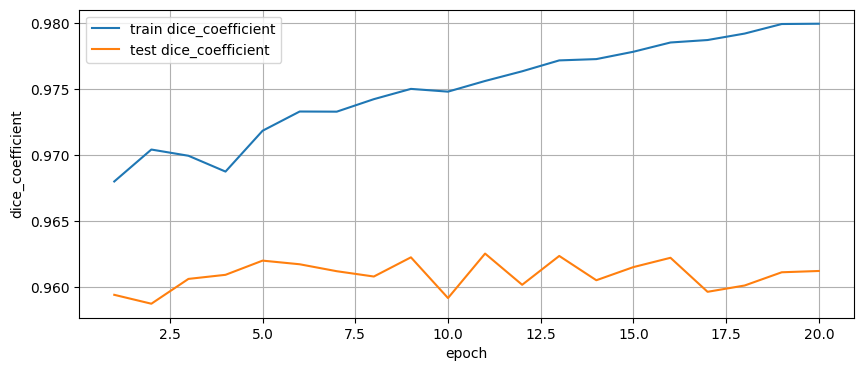


Vnet model with DiceLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0242 - accuracy: 0.9908 - dice_coefficient: 0.9771 - jaccard_index: 0.9486 - sensitivity: 0.9771 - specificity: 0.9959 - f1_score_metric: 0.9765 - hausdorff_distance: 0.8941 - miou_metric: 0.9541 ] [ val_loss: 0.0399 - val_accuracy: 0.9852 - val_dice_coefficient: 0.9607 - val_jaccard_index: 0.9185 - val_sensitivity: 0.9635 - val_specificity: 0.9920 - val_f1_score_metric: 0.9596 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9224 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0218 - accuracy: 0.9914 - dice_coefficient: 0.9789 - jaccard_index: 0.9520 - sensitivity: 0.9789 - specificity: 0.9962 - f1_score_metric: 0.9783 - hausdorff_distance: 0.8353 - miou_metric: 0.9576 ] [ val_loss: 0.0417 - val_accuracy: 0.9847 - val_dice_coefficient: 0.9588 - val_jaccard_index: 0.9138 - val_sensitivity: 0.9517 - val_specificity: 0.9937 - val_f1_score_metric: 0.9589 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9211 ]
Epoch: 3/

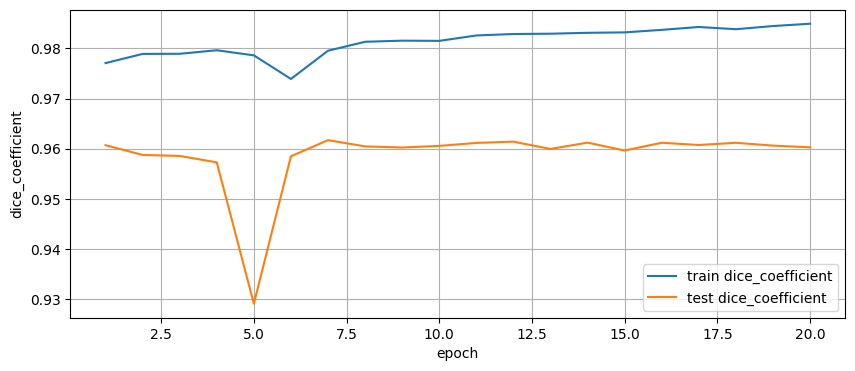


Vnet model with DiceBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0191 - accuracy: 0.9929 - dice_coefficient: 0.9842 - jaccard_index: 0.9619 - sensitivity: 0.9841 - specificity: 0.9972 - f1_score_metric: 0.9836 - hausdorff_distance: 0.2235 - miou_metric: 0.9677 ] [ val_loss: 0.0572 - val_accuracy: 0.9857 - val_dice_coefficient: 0.9620 - val_jaccard_index: 0.9203 - val_sensitivity: 0.9590 - val_specificity: 0.9935 - val_f1_score_metric: 0.9617 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9263 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0136 - accuracy: 0.9937 - dice_coefficient: 0.9868 - jaccard_index: 0.9668 - sensitivity: 0.9867 - specificity: 0.9976 - f1_score_metric: 0.9860 - hausdorff_distance: 0.0235 - miou_metric: 0.9724 ] [ val_loss: 0.0653 - val_accuracy: 0.9851 - val_dice_coefficient: 0.9604 - val_jaccard_index: 0.9177 - val_sensitivity: 0.9627 - val_specificity: 0.9921 - val_f1_score_metric: 0.9596 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9225 ]
Epoch:

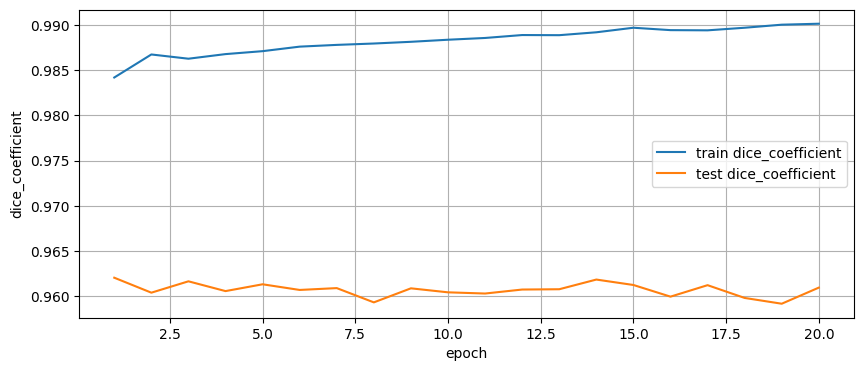


Vnet model with HybridLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0066 - accuracy: 0.9944 - dice_coefficient: 0.9893 - jaccard_index: 0.9716 - sensitivity: 0.9895 - specificity: 0.9980 - f1_score_metric: 0.9883 - hausdorff_distance: 0.0118 - miou_metric: 0.9769 ] [ val_loss: 0.0499 - val_accuracy: 0.9856 - val_dice_coefficient: 0.9616 - val_jaccard_index: 0.9196 - val_sensitivity: 0.9589 - val_specificity: 0.9933 - val_f1_score_metric: 0.9612 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9254 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0054 - accuracy: 0.9949 - dice_coefficient: 0.9909 - jaccard_index: 0.9748 - sensitivity: 0.9912 - specificity: 0.9983 - f1_score_metric: 0.9898 - hausdorff_distance: 0.0000 - miou_metric: 0.9798 ] [ val_loss: 0.0583 - val_accuracy: 0.9855 - val_dice_coefficient: 0.9615 - val_jaccard_index: 0.9196 - val_sensitivity: 0.9618 - val_specificity: 0.9927 - val_f1_score_metric: 0.9608 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9246 ]
Epoch: 

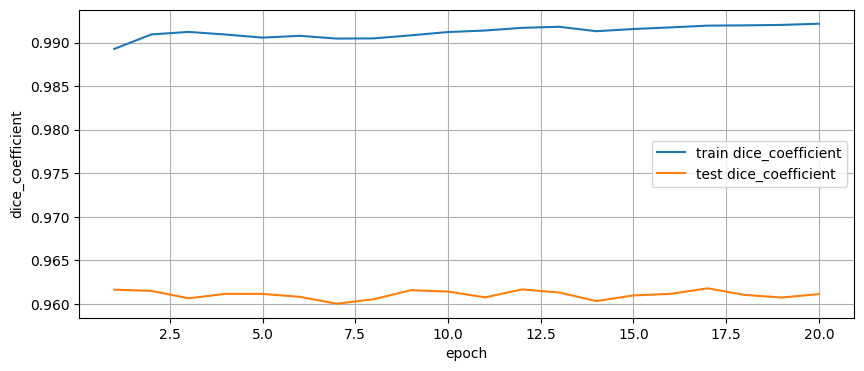


Vnet model with BinaryLovaszLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8522 - accuracy: 0.9937 - dice_coefficient: 0.9864 - jaccard_index: 0.9625 - sensitivity: 0.9759 - specificity: 0.9995 - f1_score_metric: 0.9896 - hausdorff_distance: 0.4353 - miou_metric: 0.9794 ] [ val_loss: 0.8718 - val_accuracy: 0.9846 - val_dice_coefficient: 0.9580 - val_jaccard_index: 0.9114 - val_sensitivity: 0.9424 - val_specificity: 0.9953 - val_f1_score_metric: 0.9594 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9220 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.8522 - accuracy: 0.9935 - dice_coefficient: 0.9859 - jaccard_index: 0.9615 - sensitivity: 0.9751 - specificity: 0.9995 - f1_score_metric: 0.9890 - hausdorff_distance: 0.5059 - miou_metric: 0.9782 ] [ val_loss: 0.8727 - val_accuracy: 0.9844 - val_dice_coefficient: 0.9575 - val_jaccard_index: 0.9104 - val_sensitivity: 0.9422 - val_specificity: 0.9951 - val_f1_score_metric: 0.9587 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9208 ]
E

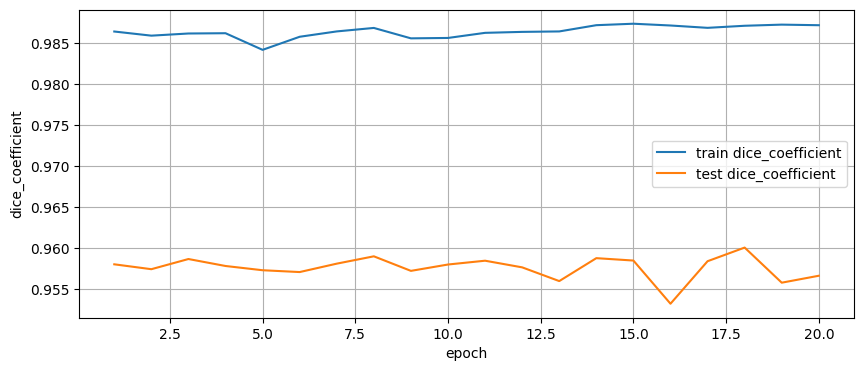


Vnet model with LovaszBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8676 - accuracy: 0.9946 - dice_coefficient: 0.9900 - jaccard_index: 0.9716 - sensitivity: 0.9866 - specificity: 0.9988 - f1_score_metric: 0.9903 - hausdorff_distance: 0.0235 - miou_metric: 0.9809 ] [ val_loss: 0.9941 - val_accuracy: 0.9856 - val_dice_coefficient: 0.9615 - val_jaccard_index: 0.9185 - val_sensitivity: 0.9535 - val_specificity: 0.9944 - val_f1_score_metric: 0.9619 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9267 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.8587 - accuracy: 0.9952 - dice_coefficient: 0.9920 - jaccard_index: 0.9750 - sensitivity: 0.9887 - specificity: 0.9992 - f1_score_metric: 0.9925 - hausdorff_distance: 0.0000 - miou_metric: 0.9851 ] [ val_loss: 1.0115 - val_accuracy: 0.9858 - val_dice_coefficient: 0.9620 - val_jaccard_index: 0.9199 - val_sensitivity: 0.9557 - val_specificity: 0.9941 - val_f1_score_metric: 0.9621 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9270 ]
Epoc

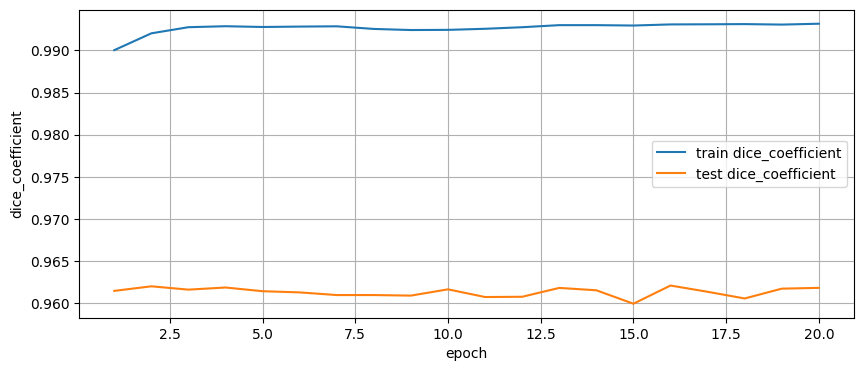


ResUnetPlus model with MSELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.1104 - accuracy: 0.9248 - dice_coefficient: 0.6883 - jaccard_index: 0.5834 - sensitivity: 0.6826 - specificity: 0.9707 - f1_score_metric: 0.6876 - hausdorff_distance: 7.3866 - miou_metric: 0.5860 ] [ val_loss: 0.0843 - val_accuracy: 0.9563 - val_dice_coefficient: 0.8589 - val_jaccard_index: 0.7461 - val_sensitivity: 0.7940 - val_specificity: 0.9898 - val_f1_score_metric: 0.8609 - val_hausdorff_distance: 2.8009 - val_miou_metric: 0.7560 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0327 - accuracy: 0.9694 - dice_coefficient: 0.9056 - jaccard_index: 0.8222 - sensitivity: 0.8958 - specificity: 0.9854 - f1_score_metric: 0.9054 - hausdorff_distance: 1.9553 - miou_metric: 0.8275 ] [ val_loss: 0.0236 - val_accuracy: 0.9731 - val_dice_coefficient: 0.9234 - val_jaccard_index: 0.8526 - val_sensitivity: 0.9389 - val_specificity: 0.9822 - val_f1_score_metric: 0.9223 - val_hausdorff_distance: 1.5096 - val_miou_metric: 0.8559 ]
Epo

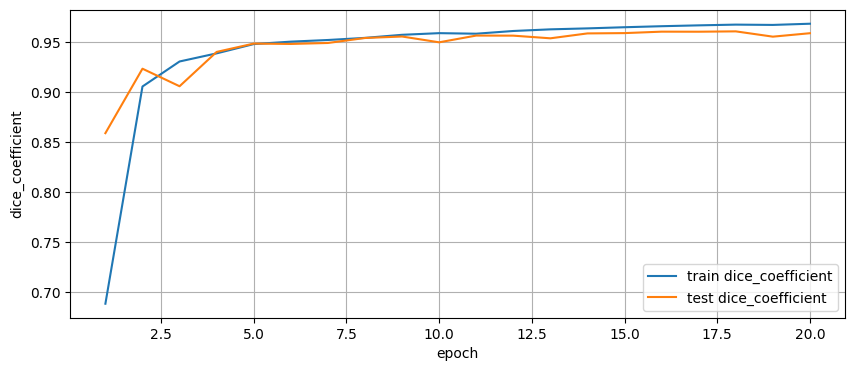


ResUnetPlus model with BCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0338 - accuracy: 0.9856 - dice_coefficient: 0.9597 - jaccard_index: 0.9164 - sensitivity: 0.9576 - specificity: 0.9932 - f1_score_metric: 0.9595 - hausdorff_distance: 1.0146 - miou_metric: 0.9223 ] [ val_loss: 0.0340 - val_accuracy: 0.9846 - val_dice_coefficient: 0.9583 - val_jaccard_index: 0.9130 - val_sensitivity: 0.9521 - val_specificity: 0.9934 - val_f1_score_metric: 0.9585 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9204 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0263 - accuracy: 0.9874 - dice_coefficient: 0.9657 - jaccard_index: 0.9272 - sensitivity: 0.9638 - specificity: 0.9942 - f1_score_metric: 0.9655 - hausdorff_distance: 1.0000 - miou_metric: 0.9334 ] [ val_loss: 0.0333 - val_accuracy: 0.9845 - val_dice_coefficient: 0.9582 - val_jaccard_index: 0.9129 - val_sensitivity: 0.9533 - val_specificity: 0.9931 - val_f1_score_metric: 0.9582 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9197 ]
Epo

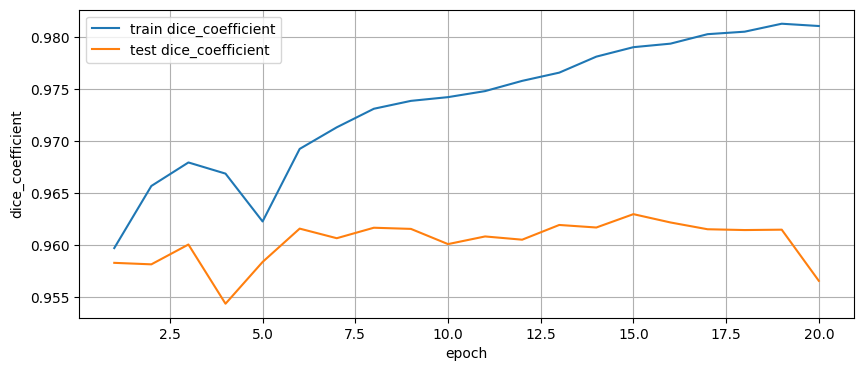


ResUnetPlus model with FocalLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0001 - accuracy: 0.9913 - dice_coefficient: 0.9786 - jaccard_index: 0.9514 - sensitivity: 0.9782 - specificity: 0.9962 - f1_score_metric: 0.9782 - hausdorff_distance: 0.6824 - miou_metric: 0.9574 ] [ val_loss: 0.0007 - val_accuracy: 0.9858 - val_dice_coefficient: 0.9624 - val_jaccard_index: 0.9209 - val_sensitivity: 0.9594 - val_specificity: 0.9935 - val_f1_score_metric: 0.9621 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9270 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0001 - accuracy: 0.9929 - dice_coefficient: 0.9838 - jaccard_index: 0.9612 - sensitivity: 0.9836 - specificity: 0.9971 - f1_score_metric: 0.9832 - hausdorff_distance: 0.2471 - miou_metric: 0.9670 ] [ val_loss: 0.0007 - val_accuracy: 0.9859 - val_dice_coefficient: 0.9625 - val_jaccard_index: 0.9210 - val_sensitivity: 0.9597 - val_specificity: 0.9935 - val_f1_score_metric: 0.9624 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9276 ]
E

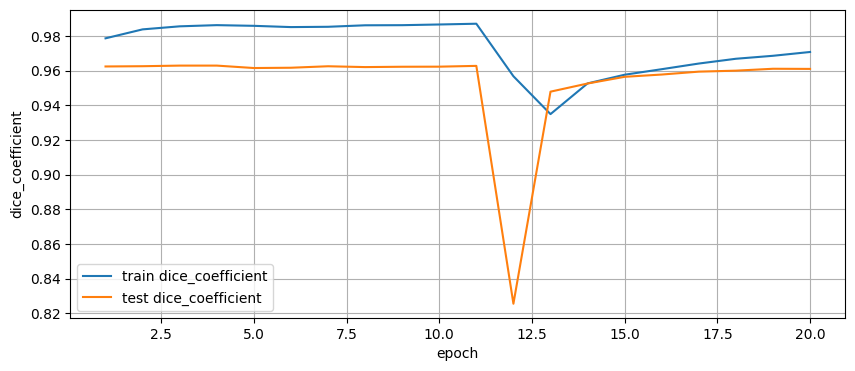


ResUnetPlus model with DiceLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0386 - accuracy: 0.9867 - dice_coefficient: 0.9635 - jaccard_index: 0.9233 - sensitivity: 0.9631 - specificity: 0.9935 - f1_score_metric: 0.9631 - hausdorff_distance: 1.0000 - miou_metric: 0.9288 ] [ val_loss: 0.0415 - val_accuracy: 0.9850 - val_dice_coefficient: 0.9594 - val_jaccard_index: 0.9145 - val_sensitivity: 0.9512 - val_specificity: 0.9941 - val_f1_score_metric: 0.9600 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9231 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0299 - accuracy: 0.9889 - dice_coefficient: 0.9708 - jaccard_index: 0.9369 - sensitivity: 0.9714 - specificity: 0.9946 - f1_score_metric: 0.9702 - hausdorff_distance: 0.9882 - miou_metric: 0.9422 ] [ val_loss: 0.0412 - val_accuracy: 0.9849 - val_dice_coefficient: 0.9592 - val_jaccard_index: 0.9139 - val_sensitivity: 0.9466 - val_specificity: 0.9949 - val_f1_score_metric: 0.9601 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9233 ]
Ep

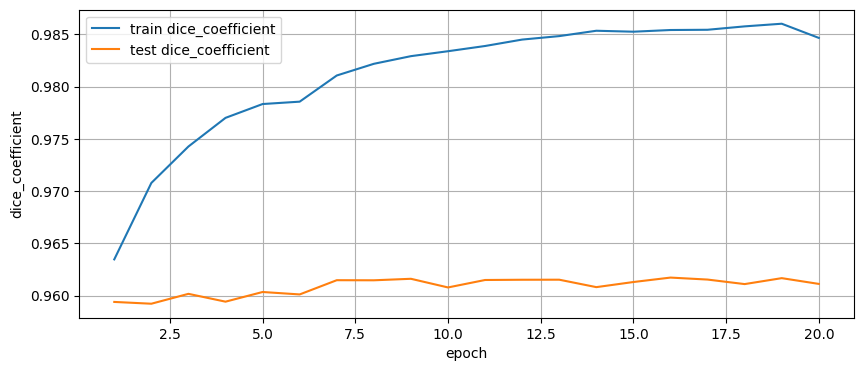


ResUnetPlus model with DiceBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0171 - accuracy: 0.9932 - dice_coefficient: 0.9851 - jaccard_index: 0.9641 - sensitivity: 0.9865 - specificity: 0.9971 - f1_score_metric: 0.9840 - hausdorff_distance: 0.0941 - miou_metric: 0.9686 ] [ val_loss: 0.0494 - val_accuracy: 0.9858 - val_dice_coefficient: 0.9622 - val_jaccard_index: 0.9206 - val_sensitivity: 0.9597 - val_specificity: 0.9934 - val_f1_score_metric: 0.9618 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9265 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0121 - accuracy: 0.9941 - dice_coefficient: 0.9880 - jaccard_index: 0.9692 - sensitivity: 0.9882 - specificity: 0.9978 - f1_score_metric: 0.9870 - hausdorff_distance: 0.0118 - miou_metric: 0.9744 ] [ val_loss: 0.0499 - val_accuracy: 0.9857 - val_dice_coefficient: 0.9620 - val_jaccard_index: 0.9200 - val_sensitivity: 0.9583 - val_specificity: 0.9936 - val_f1_score_metric: 0.9619 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9267 ]

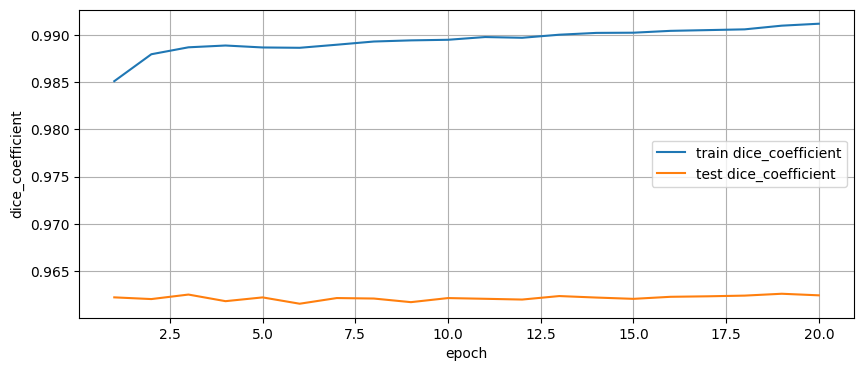


ResUnetPlus model with HybridLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0055 - accuracy: 0.9948 - dice_coefficient: 0.9907 - jaccard_index: 0.9743 - sensitivity: 0.9909 - specificity: 0.9983 - f1_score_metric: 0.9895 - hausdorff_distance: 0.0000 - miou_metric: 0.9792 ] [ val_loss: 0.0498 - val_accuracy: 0.9858 - val_dice_coefficient: 0.9623 - val_jaccard_index: 0.9207 - val_sensitivity: 0.9592 - val_specificity: 0.9935 - val_f1_score_metric: 0.9620 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9269 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0054 - accuracy: 0.9949 - dice_coefficient: 0.9908 - jaccard_index: 0.9746 - sensitivity: 0.9910 - specificity: 0.9983 - f1_score_metric: 0.9897 - hausdorff_distance: 0.0000 - miou_metric: 0.9796 ] [ val_loss: 0.0494 - val_accuracy: 0.9855 - val_dice_coefficient: 0.9612 - val_jaccard_index: 0.9185 - val_sensitivity: 0.9569 - val_specificity: 0.9936 - val_f1_score_metric: 0.9610 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9250 ]


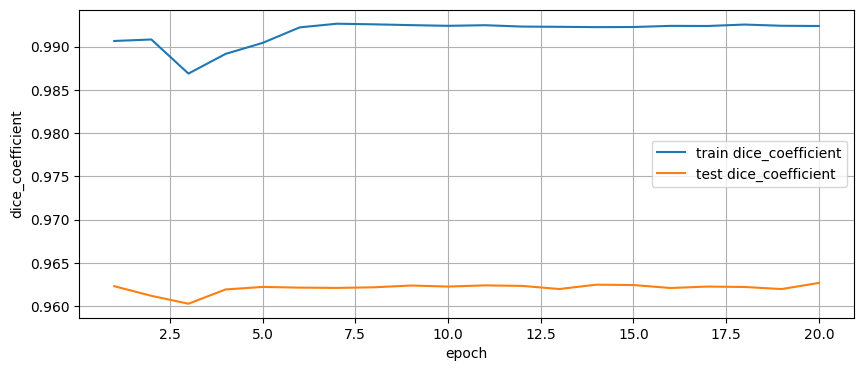


ResUnetPlus model with BinaryLovaszLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8518 - accuracy: 0.9939 - dice_coefficient: 0.9874 - jaccard_index: 0.9644 - sensitivity: 0.9779 - specificity: 0.9995 - f1_score_metric: 0.9904 - hausdorff_distance: 0.2588 - miou_metric: 0.9811 ] [ val_loss: 0.8732 - val_accuracy: 0.9852 - val_dice_coefficient: 0.9601 - val_jaccard_index: 0.9156 - val_sensitivity: 0.9492 - val_specificity: 0.9947 - val_f1_score_metric: 0.9609 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9248 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.8516 - accuracy: 0.9938 - dice_coefficient: 0.9871 - jaccard_index: 0.9638 - sensitivity: 0.9773 - specificity: 0.9995 - f1_score_metric: 0.9900 - hausdorff_distance: 0.3059 - miou_metric: 0.9802 ] [ val_loss: 0.8689 - val_accuracy: 0.9845 - val_dice_coefficient: 0.9576 - val_jaccard_index: 0.9103 - val_sensitivity: 0.9382 - val_specificity: 0.9960 - val_f1_score_metric: 0.9593 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9

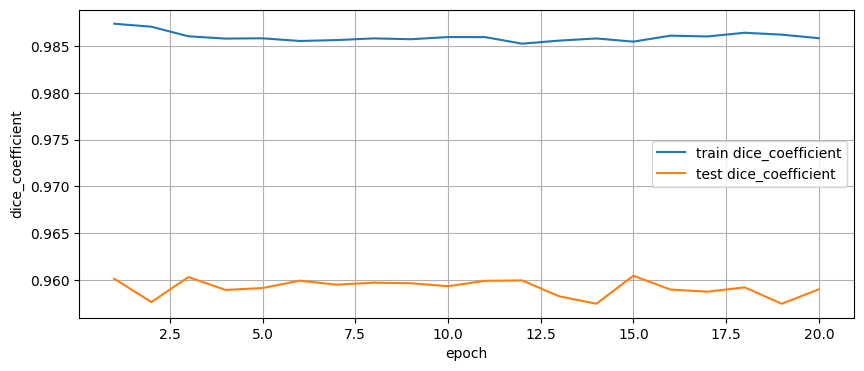


ResUnetPlus model with LovaszBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8693 - accuracy: 0.9944 - dice_coefficient: 0.9893 - jaccard_index: 0.9701 - sensitivity: 0.9855 - specificity: 0.9988 - f1_score_metric: 0.9897 - hausdorff_distance: 0.0235 - miou_metric: 0.9796 ] [ val_loss: 0.9768 - val_accuracy: 0.9858 - val_dice_coefficient: 0.9619 - val_jaccard_index: 0.9192 - val_sensitivity: 0.9529 - val_specificity: 0.9947 - val_f1_score_metric: 0.9625 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9277 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.8592 - accuracy: 0.9951 - dice_coefficient: 0.9916 - jaccard_index: 0.9742 - sensitivity: 0.9881 - specificity: 0.9991 - f1_score_metric: 0.9922 - hausdorff_distance: 0.0000 - miou_metric: 0.9845 ] [ val_loss: 0.9702 - val_accuracy: 0.9859 - val_dice_coefficient: 0.9626 - val_jaccard_index: 0.9209 - val_sensitivity: 0.9574 - val_specificity: 0.9940 - val_f1_score_metric: 0.9625 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9278

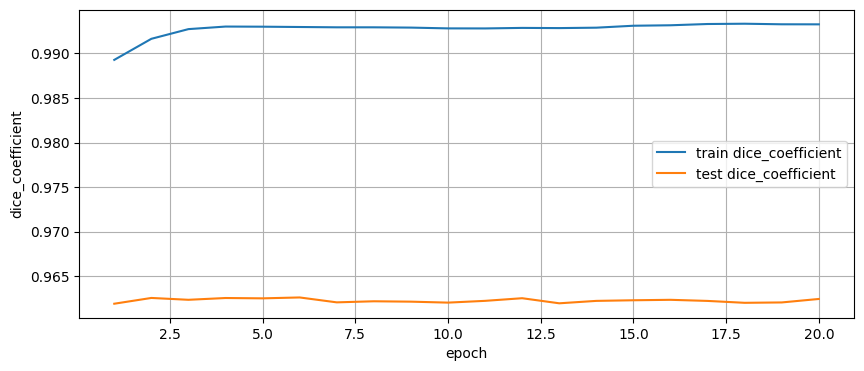

R2Unet model with MSELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0860 - accuracy: 0.9286 - dice_coefficient: 0.8226 - jaccard_index: 0.7124 - sensitivity: 0.8573 - specificity: 0.9445 - f1_score_metric: 0.8214 - hausdorff_distance: 5.3750 - miou_metric: 0.7149 ] [ val_loss: 0.0736 - val_accuracy: 0.9212 - val_dice_coefficient: 0.7550 - val_jaccard_index: 0.6036 - val_sensitivity: 0.7440 - val_specificity: 0.9573 - val_f1_score_metric: 0.7556 - val_hausdorff_distance: 17.8831 - val_miou_metric: 0.6090 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0296 - accuracy: 0.9708 - dice_coefficient: 0.9106 - jaccard_index: 0.8308 - sensitivity: 0.9063 - specificity: 0.9853 - f1_score_metric: 0.9103 - hausdorff_distance: 1.7754 - miou_metric: 0.8356 ] [ val_loss: 0.0267 - val_accuracy: 0.9705 - val_dice_coefficient: 0.9136 - val_jaccard_index: 0.8351 - val_sensitivity: 0.9082 - val_specificity: 0.9850 - val_f1_score_metric: 0.9136 - val_hausdorff_distance: 1.8141 - val_miou_metric: 0.8411 ]
Epoch: 3

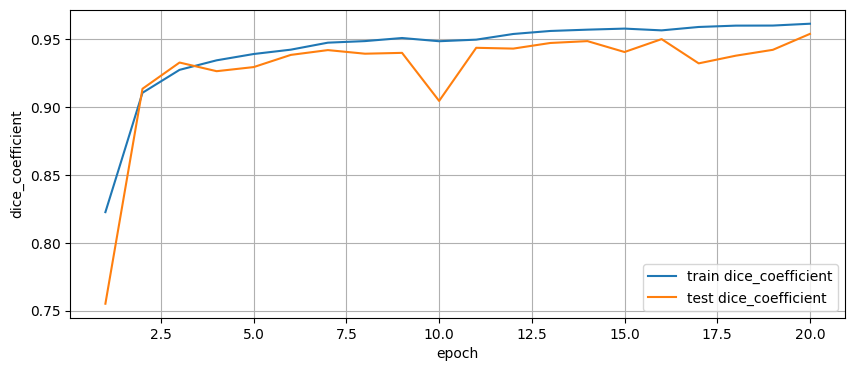


R2Unet model with BCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0440 - accuracy: 0.9819 - dice_coefficient: 0.9474 - jaccard_index: 0.8942 - sensitivity: 0.9444 - specificity: 0.9913 - f1_score_metric: 0.9472 - hausdorff_distance: 1.1151 - miou_metric: 0.9000 ] [ val_loss: 0.0445 - val_accuracy: 0.9812 - val_dice_coefficient: 0.9482 - val_jaccard_index: 0.8961 - val_sensitivity: 0.9545 - val_specificity: 0.9890 - val_f1_score_metric: 0.9470 - val_hausdorff_distance: 1.0197 - val_miou_metric: 0.8993 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0383 - accuracy: 0.9828 - dice_coefficient: 0.9504 - jaccard_index: 0.8994 - sensitivity: 0.9473 - specificity: 0.9919 - f1_score_metric: 0.9503 - hausdorff_distance: 1.0292 - miou_metric: 0.9053 ] [ val_loss: 0.0464 - val_accuracy: 0.9796 - val_dice_coefficient: 0.9431 - val_jaccard_index: 0.8870 - val_sensitivity: 0.9478 - val_specificity: 0.9882 - val_f1_score_metric: 0.9420 - val_hausdorff_distance: 1.0394 - val_miou_metric: 0.8904 ]
Epoch: 3

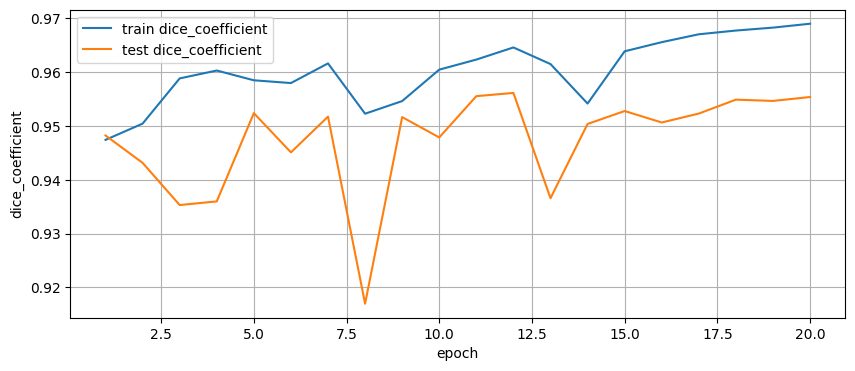


R2Unet model with FocalLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0003 - accuracy: 0.9871 - dice_coefficient: 0.9645 - jaccard_index: 0.9252 - sensitivity: 0.9640 - specificity: 0.9938 - f1_score_metric: 0.9641 - hausdorff_distance: 1.0000 - miou_metric: 0.9308 ] [ val_loss: 0.0009 - val_accuracy: 0.9814 - val_dice_coefficient: 0.9495 - val_jaccard_index: 0.8995 - val_sensitivity: 0.9677 - val_specificity: 0.9867 - val_f1_score_metric: 0.9471 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.8996 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0002 - accuracy: 0.9883 - dice_coefficient: 0.9687 - jaccard_index: 0.9328 - sensitivity: 0.9684 - specificity: 0.9945 - f1_score_metric: 0.9683 - hausdorff_distance: 1.0000 - miou_metric: 0.9386 ] [ val_loss: 0.0013 - val_accuracy: 0.9809 - val_dice_coefficient: 0.9472 - val_jaccard_index: 0.8947 - val_sensitivity: 0.9508 - val_specificity: 0.9893 - val_f1_score_metric: 0.9456 - val_hausdorff_distance: 1.0476 - val_miou_metric: 0.8969 ]
Epoch:

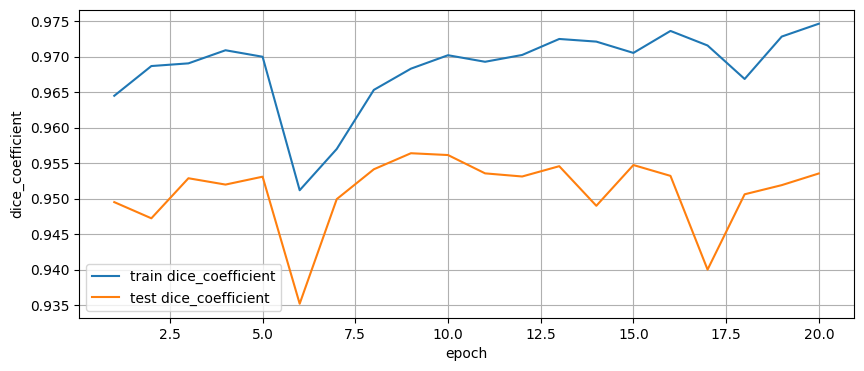


R2Unet model with DiceLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0321 - accuracy: 0.9886 - dice_coefficient: 0.9696 - jaccard_index: 0.9348 - sensitivity: 0.9703 - specificity: 0.9945 - f1_score_metric: 0.9691 - hausdorff_distance: 1.0000 - miou_metric: 0.9401 ] [ val_loss: 0.0519 - val_accuracy: 0.9817 - val_dice_coefficient: 0.9490 - val_jaccard_index: 0.8966 - val_sensitivity: 0.9388 - val_specificity: 0.9926 - val_f1_score_metric: 0.9487 - val_hausdorff_distance: 1.0871 - val_miou_metric: 0.9025 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0296 - accuracy: 0.9890 - dice_coefficient: 0.9710 - jaccard_index: 0.9374 - sensitivity: 0.9720 - specificity: 0.9946 - f1_score_metric: 0.9704 - hausdorff_distance: 1.0000 - miou_metric: 0.9426 ] [ val_loss: 0.0474 - val_accuracy: 0.9829 - val_dice_coefficient: 0.9531 - val_jaccard_index: 0.9040 - val_sensitivity: 0.9481 - val_specificity: 0.9922 - val_f1_score_metric: 0.9527 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9097 ]
Epoch: 

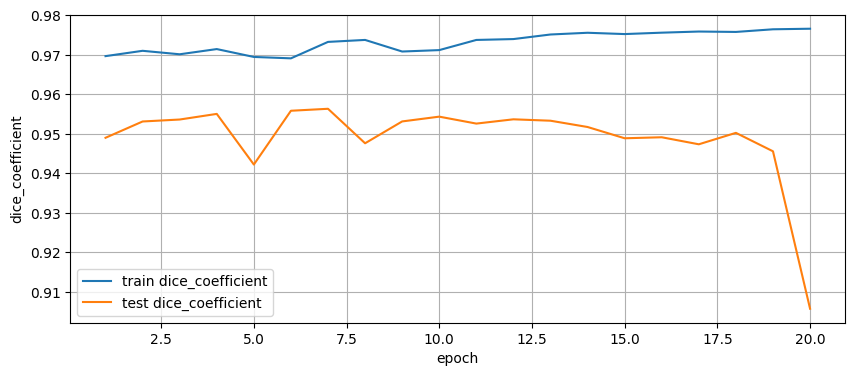


R2Unet model with DiceBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0277 - accuracy: 0.9906 - dice_coefficient: 0.9763 - jaccard_index: 0.9475 - sensitivity: 0.9785 - specificity: 0.9954 - f1_score_metric: 0.9755 - hausdorff_distance: 0.8824 - miou_metric: 0.9522 ] [ val_loss: 0.0689 - val_accuracy: 0.9821 - val_dice_coefficient: 0.9508 - val_jaccard_index: 0.9006 - val_sensitivity: 0.9496 - val_specificity: 0.9910 - val_f1_score_metric: 0.9498 - val_hausdorff_distance: 1.0197 - val_miou_metric: 0.9045 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0213 - accuracy: 0.9913 - dice_coefficient: 0.9786 - jaccard_index: 0.9515 - sensitivity: 0.9791 - specificity: 0.9961 - f1_score_metric: 0.9780 - hausdorff_distance: 0.8000 - miou_metric: 0.9569 ] [ val_loss: 0.0670 - val_accuracy: 0.9825 - val_dice_coefficient: 0.9516 - val_jaccard_index: 0.9014 - val_sensitivity: 0.9433 - val_specificity: 0.9926 - val_f1_score_metric: 0.9511 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9068 ]
Epoc

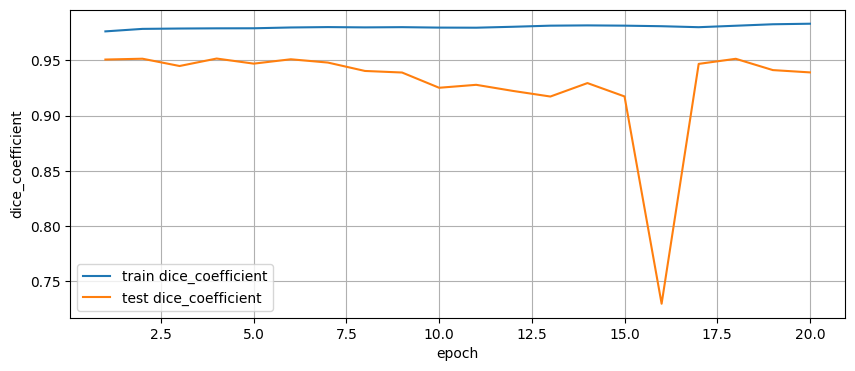


R2Unet model with HybridLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0103 - accuracy: 0.9924 - dice_coefficient: 0.9822 - jaccard_index: 0.9581 - sensitivity: 0.9815 - specificity: 0.9970 - f1_score_metric: 0.9818 - hausdorff_distance: 0.4471 - miou_metric: 0.9643 ] [ val_loss: 0.1165 - val_accuracy: 0.9786 - val_dice_coefficient: 0.9381 - val_jaccard_index: 0.8763 - val_sensitivity: 0.9094 - val_specificity: 0.9945 - val_f1_score_metric: 0.9388 - val_hausdorff_distance: 1.3204 - val_miou_metric: 0.8848 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0095 - accuracy: 0.9927 - dice_coefficient: 0.9834 - jaccard_index: 0.9604 - sensitivity: 0.9831 - specificity: 0.9971 - f1_score_metric: 0.9829 - hausdorff_distance: 0.3412 - miou_metric: 0.9664 ] [ val_loss: 0.1073 - val_accuracy: 0.9787 - val_dice_coefficient: 0.9384 - val_jaccard_index: 0.8768 - val_sensitivity: 0.9112 - val_specificity: 0.9942 - val_f1_score_metric: 0.9391 - val_hausdorff_distance: 1.2446 - val_miou_metric: 0.8854 ]
Epoch

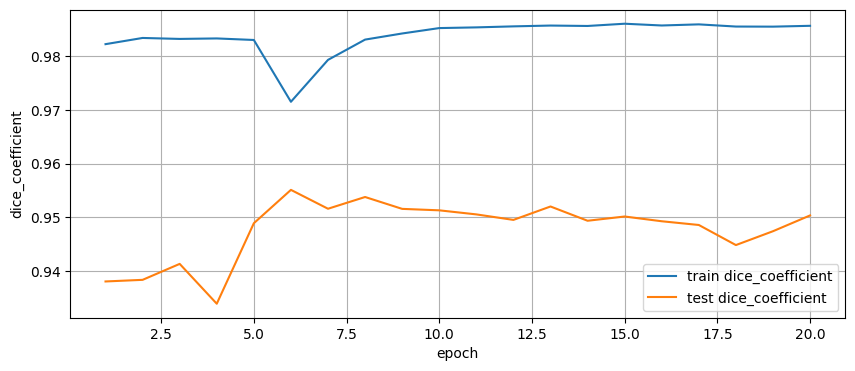


R2Unet model with BinaryLovaszLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8572 - accuracy: 0.9900 - dice_coefficient: 0.9738 - jaccard_index: 0.9383 - sensitivity: 0.9527 - specificity: 0.9993 - f1_score_metric: 0.9778 - hausdorff_distance: 0.9882 - miou_metric: 0.9567 ] [ val_loss: 0.8789 - val_accuracy: 0.9806 - val_dice_coefficient: 0.9450 - val_jaccard_index: 0.8882 - val_sensitivity: 0.9219 - val_specificity: 0.9945 - val_f1_score_metric: 0.9461 - val_hausdorff_distance: 1.0871 - val_miou_metric: 0.8977 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.8576 - accuracy: 0.9896 - dice_coefficient: 0.9723 - jaccard_index: 0.9355 - sensitivity: 0.9501 - specificity: 0.9993 - f1_score_metric: 0.9764 - hausdorff_distance: 0.9882 - miou_metric: 0.9539 ] [ val_loss: 0.8844 - val_accuracy: 0.9815 - val_dice_coefficient: 0.9485 - val_jaccard_index: 0.8951 - val_sensitivity: 0.9363 - val_specificity: 0.9929 - val_f1_score_metric: 0.9489 - val_hausdorff_distance: 1.0394 - val_miou_metric: 0.9028 ]

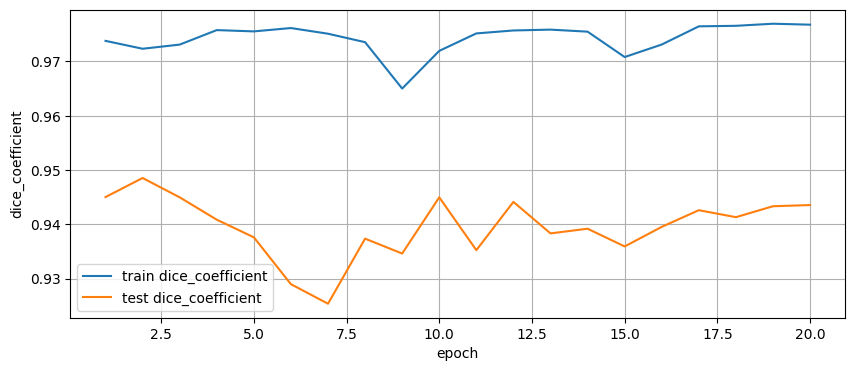


R2Unet model with LovaszBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8798 - accuracy: 0.9925 - dice_coefficient: 0.9826 - jaccard_index: 0.9574 - sensitivity: 0.9755 - specificity: 0.9982 - f1_score_metric: 0.9838 - hausdorff_distance: 0.5529 - miou_metric: 0.9680 ] [ val_loss: 0.9923 - val_accuracy: 0.9795 - val_dice_coefficient: 0.9409 - val_jaccard_index: 0.8800 - val_sensitivity: 0.9073 - val_specificity: 0.9960 - val_f1_score_metric: 0.9428 - val_hausdorff_distance: 1.2054 - val_miou_metric: 0.8918 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.8694 - accuracy: 0.9932 - dice_coefficient: 0.9849 - jaccard_index: 0.9611 - sensitivity: 0.9767 - specificity: 0.9988 - f1_score_metric: 0.9865 - hausdorff_distance: 0.3412 - miou_metric: 0.9734 ] [ val_loss: 0.9892 - val_accuracy: 0.9804 - val_dice_coefficient: 0.9442 - val_jaccard_index: 0.8866 - val_sensitivity: 0.9173 - val_specificity: 0.9952 - val_f1_score_metric: 0.9456 - val_hausdorff_distance: 1.1462 - val_miou_metric: 0.8969 ]
Ep

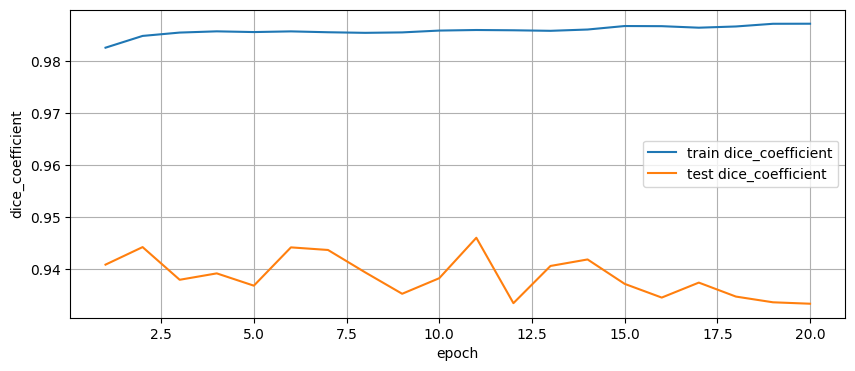

MultiResUnet model with MSELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0440 - accuracy: 0.9462 - dice_coefficient: 0.8617 - jaccard_index: 0.7681 - sensitivity: 0.8808 - specificity: 0.9608 - f1_score_metric: 0.8610 - hausdorff_distance: 4.3452 - miou_metric: 0.7720 ] [ val_loss: 0.0167 - val_accuracy: 0.9767 - val_dice_coefficient: 0.9342 - val_jaccard_index: 0.8715 - val_sensitivity: 0.9423 - val_specificity: 0.9858 - val_f1_score_metric: 0.9329 - val_hausdorff_distance: 1.1660 - val_miou_metric: 0.8744 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0141 - accuracy: 0.9788 - dice_coefficient: 0.9372 - jaccard_index: 0.8760 - sensitivity: 0.9362 - specificity: 0.9893 - f1_score_metric: 0.9368 - hausdorff_distance: 1.1609 - miou_metric: 0.8813 ] [ val_loss: 0.0127 - val_accuracy: 0.9801 - val_dice_coefficient: 0.9438 - val_jaccard_index: 0.8865 - val_sensitivity: 0.9310 - val_specificity: 0.9921 - val_f1_score_metric: 0.9444 - val_hausdorff_distance: 1.0592 - val_miou_metric: 0.8946 ]
Epo

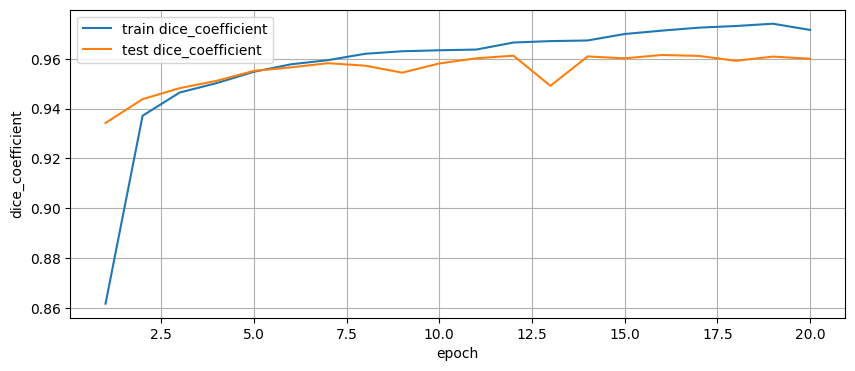


MultiResUnet model with BCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0244 - accuracy: 0.9881 - dice_coefficient: 0.9681 - jaccard_index: 0.9317 - sensitivity: 0.9672 - specificity: 0.9945 - f1_score_metric: 0.9678 - hausdorff_distance: 1.0000 - miou_metric: 0.9376 ] [ val_loss: 0.0321 - val_accuracy: 0.9856 - val_dice_coefficient: 0.9616 - val_jaccard_index: 0.9195 - val_sensitivity: 0.9593 - val_specificity: 0.9933 - val_f1_score_metric: 0.9614 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9257 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0204 - accuracy: 0.9894 - dice_coefficient: 0.9723 - jaccard_index: 0.9396 - sensitivity: 0.9720 - specificity: 0.9951 - f1_score_metric: 0.9719 - hausdorff_distance: 0.9882 - miou_metric: 0.9454 ] [ val_loss: 0.0331 - val_accuracy: 0.9852 - val_dice_coefficient: 0.9606 - val_jaccard_index: 0.9176 - val_sensitivity: 0.9597 - val_specificity: 0.9928 - val_f1_score_metric: 0.9602 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9235 ]
Ep

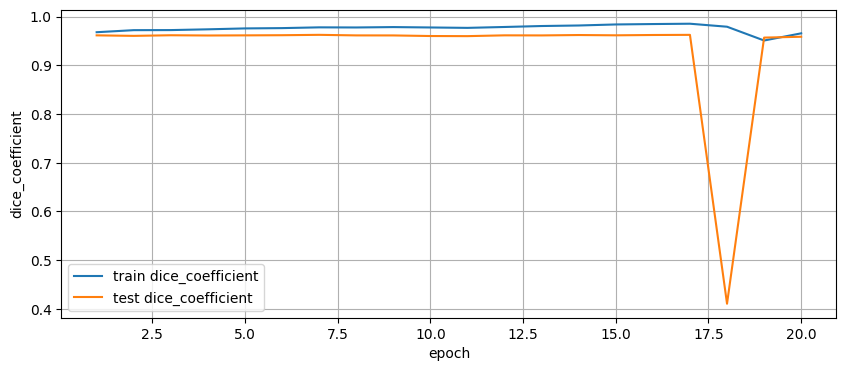


MultiResUnet model with FocalLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0003 - accuracy: 0.9883 - dice_coefficient: 0.9685 - jaccard_index: 0.9326 - sensitivity: 0.9681 - specificity: 0.9945 - f1_score_metric: 0.9682 - hausdorff_distance: 1.0000 - miou_metric: 0.9384 ] [ val_loss: 0.0005 - val_accuracy: 0.9850 - val_dice_coefficient: 0.9598 - val_jaccard_index: 0.9168 - val_sensitivity: 0.9636 - val_specificity: 0.9917 - val_f1_score_metric: 0.9590 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9212 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0002 - accuracy: 0.9900 - dice_coefficient: 0.9743 - jaccard_index: 0.9433 - sensitivity: 0.9742 - specificity: 0.9954 - f1_score_metric: 0.9738 - hausdorff_distance: 0.9412 - miou_metric: 0.9490 ] [ val_loss: 0.0005 - val_accuracy: 0.9857 - val_dice_coefficient: 0.9620 - val_jaccard_index: 0.9201 - val_sensitivity: 0.9603 - val_specificity: 0.9932 - val_f1_score_metric: 0.9619 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9267 ]


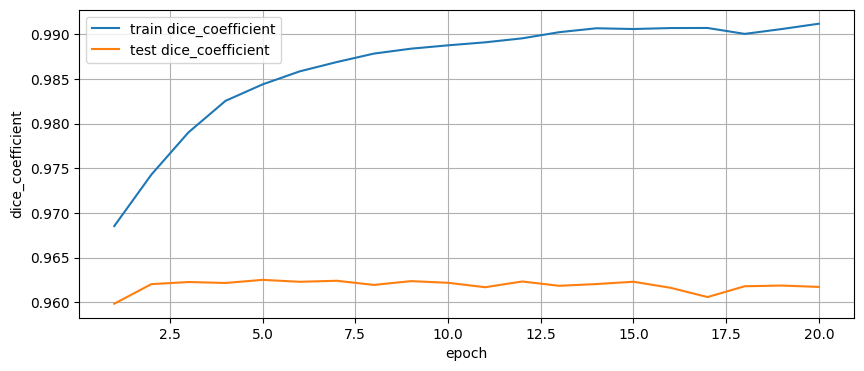


MultiResUnet model with DiceLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0134 - accuracy: 0.9938 - dice_coefficient: 0.9872 - jaccard_index: 0.9676 - sensitivity: 0.9871 - specificity: 0.9977 - f1_score_metric: 0.9864 - hausdorff_distance: 0.0471 - miou_metric: 0.9732 ] [ val_loss: 0.0406 - val_accuracy: 0.9849 - val_dice_coefficient: 0.9595 - val_jaccard_index: 0.9159 - val_sensitivity: 0.9616 - val_specificity: 0.9920 - val_f1_score_metric: 0.9589 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9210 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0146 - accuracy: 0.9934 - dice_coefficient: 0.9856 - jaccard_index: 0.9647 - sensitivity: 0.9857 - specificity: 0.9974 - f1_score_metric: 0.9848 - hausdorff_distance: 0.1059 - miou_metric: 0.9701 ] [ val_loss: 0.0395 - val_accuracy: 0.9852 - val_dice_coefficient: 0.9606 - val_jaccard_index: 0.9177 - val_sensitivity: 0.9589 - val_specificity: 0.9929 - val_f1_score_metric: 0.9601 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9234 ]
E

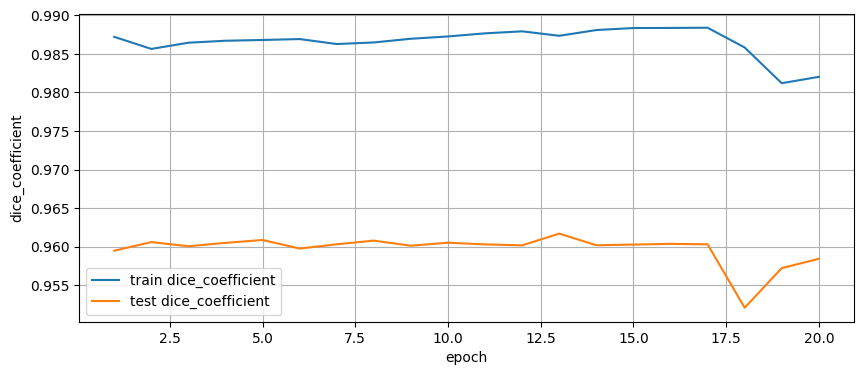


MultiResUnet model with DiceBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0202 - accuracy: 0.9934 - dice_coefficient: 0.9856 - jaccard_index: 0.9643 - sensitivity: 0.9847 - specificity: 0.9976 - f1_score_metric: 0.9851 - hausdorff_distance: 0.1176 - miou_metric: 0.9707 ] [ val_loss: 0.0643 - val_accuracy: 0.9855 - val_dice_coefficient: 0.9614 - val_jaccard_index: 0.9194 - val_sensitivity: 0.9628 - val_specificity: 0.9925 - val_f1_score_metric: 0.9607 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9243 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0104 - accuracy: 0.9946 - dice_coefficient: 0.9898 - jaccard_index: 0.9724 - sensitivity: 0.9894 - specificity: 0.9983 - f1_score_metric: 0.9890 - hausdorff_distance: 0.0000 - miou_metric: 0.9783 ] [ val_loss: 0.0594 - val_accuracy: 0.9856 - val_dice_coefficient: 0.9618 - val_jaccard_index: 0.9201 - val_sensitivity: 0.9624 - val_specificity: 0.9927 - val_f1_score_metric: 0.9610 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9250 

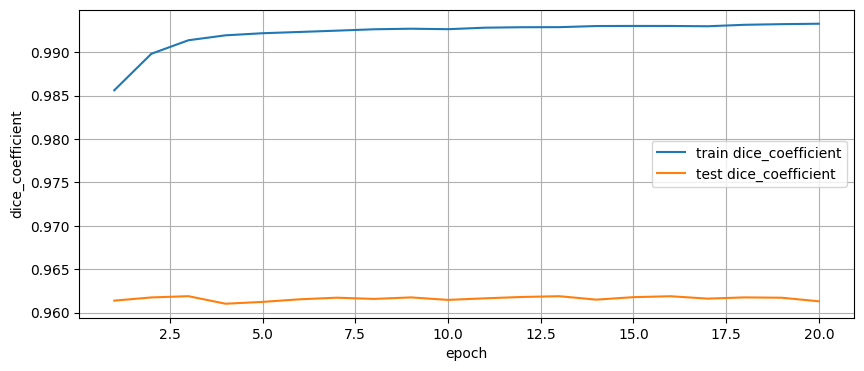


MultiResUnet model with HybridLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.0044 - accuracy: 0.9954 - dice_coefficient: 0.9928 - jaccard_index: 0.9779 - sensitivity: 0.9926 - specificity: 0.9987 - f1_score_metric: 0.9916 - hausdorff_distance: 0.0000 - miou_metric: 0.9834 ] [ val_loss: 0.0558 - val_accuracy: 0.9855 - val_dice_coefficient: 0.9615 - val_jaccard_index: 0.9196 - val_sensitivity: 0.9614 - val_specificity: 0.9928 - val_f1_score_metric: 0.9609 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9248 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.0041 - accuracy: 0.9954 - dice_coefficient: 0.9930 - jaccard_index: 0.9782 - sensitivity: 0.9928 - specificity: 0.9988 - f1_score_metric: 0.9919 - hausdorff_distance: 0.0000 - miou_metric: 0.9839 ] [ val_loss: 0.0535 - val_accuracy: 0.9855 - val_dice_coefficient: 0.9613 - val_jaccard_index: 0.9190 - val_sensitivity: 0.9610 - val_specificity: 0.9928 - val_f1_score_metric: 0.9609 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9247 ]

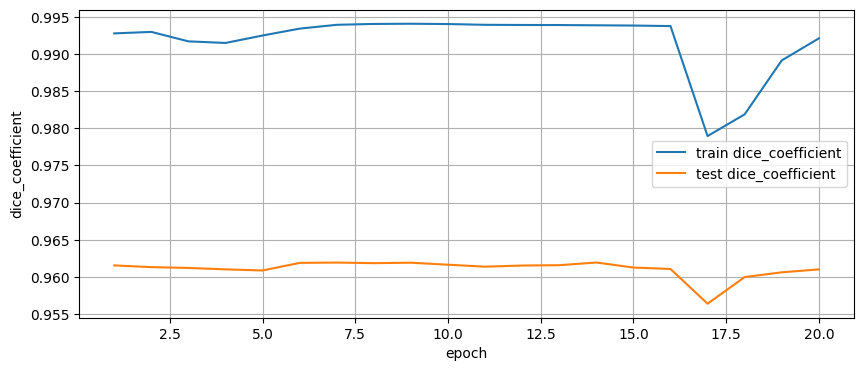


MultiResUnet model with BinaryLovaszLoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8515 - accuracy: 0.9941 - dice_coefficient: 0.9879 - jaccard_index: 0.9654 - sensitivity: 0.9789 - specificity: 0.9995 - f1_score_metric: 0.9909 - hausdorff_distance: 0.3294 - miou_metric: 0.9819 ] [ val_loss: 0.8733 - val_accuracy: 0.9848 - val_dice_coefficient: 0.9587 - val_jaccard_index: 0.9129 - val_sensitivity: 0.9459 - val_specificity: 0.9948 - val_f1_score_metric: 0.9596 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9225 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.8517 - accuracy: 0.9939 - dice_coefficient: 0.9873 - jaccard_index: 0.9643 - sensitivity: 0.9779 - specificity: 0.9995 - f1_score_metric: 0.9902 - hausdorff_distance: 0.3176 - miou_metric: 0.9805 ] [ val_loss: 0.8730 - val_accuracy: 0.9844 - val_dice_coefficient: 0.9573 - val_jaccard_index: 0.9101 - val_sensitivity: 0.9423 - val_specificity: 0.9951 - val_f1_score_metric: 0.9585 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.

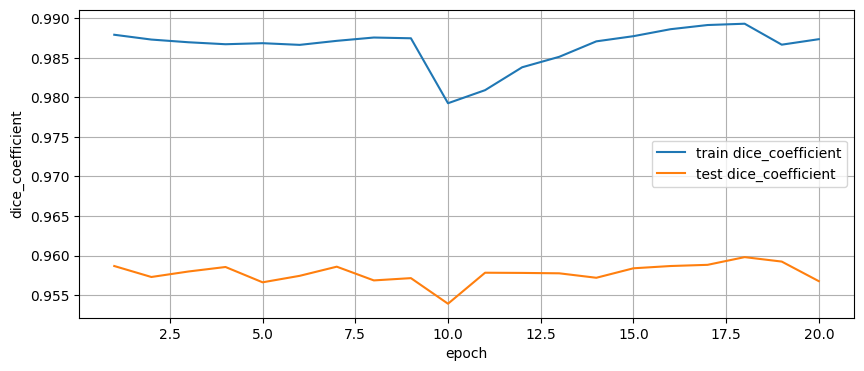


MultiResUnet model with LovaszBCELoss

Epoch: 1/20    Batch: 85/85   [ loss: 0.8732 - accuracy: 0.9947 - dice_coefficient: 0.9902 - jaccard_index: 0.9718 - sensitivity: 0.9868 - specificity: 0.9989 - f1_score_metric: 0.9905 - hausdorff_distance: 0.0118 - miou_metric: 0.9812 ] [ val_loss: 0.9729 - val_accuracy: 0.9854 - val_dice_coefficient: 0.9608 - val_jaccard_index: 0.9173 - val_sensitivity: 0.9527 - val_specificity: 0.9943 - val_f1_score_metric: 0.9613 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.9255 ]
Epoch: 2/20    Batch: 85/85   [ loss: 0.8578 - accuracy: 0.9953 - dice_coefficient: 0.9924 - jaccard_index: 0.9756 - sensitivity: 0.9891 - specificity: 0.9992 - f1_score_metric: 0.9930 - hausdorff_distance: 0.0000 - miou_metric: 0.9860 ] [ val_loss: 0.9765 - val_accuracy: 0.9856 - val_dice_coefficient: 0.9616 - val_jaccard_index: 0.9189 - val_sensitivity: 0.9555 - val_specificity: 0.9940 - val_f1_score_metric: 0.9619 - val_hausdorff_distance: 1.0000 - val_miou_metric: 0.926

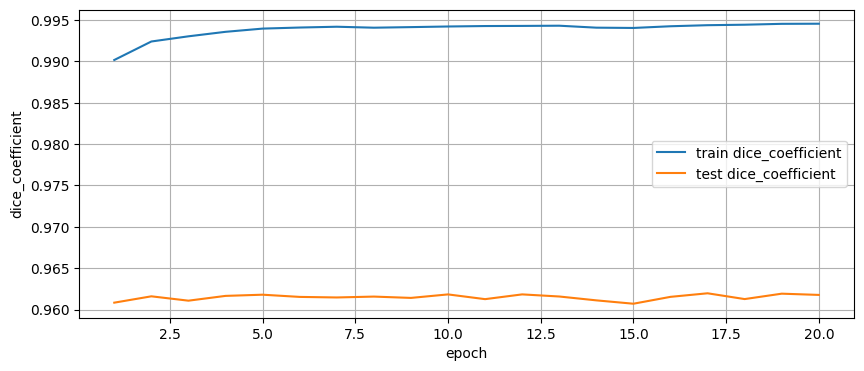